<a href="https://colab.research.google.com/github/SultanFK1/Cloud_Optmization_Model/blob/main/workload_prediction_basic_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

In [2]:
!rm -rf /content/sample_data/

In [3]:
%cd /content/

/content


In [4]:
!git clone https://github.com/alibaba/clusterdata.git

Cloning into 'clusterdata'...
remote: Enumerating objects: 559, done.
remote: Counting objects: 100% (99/99), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 559 (delta 43), reused 88 (delta 37), pack-reused 460 (from 1)
Receiving objects: 100% (559/559), 24.39 MiB | 26.92 MiB/s, done.
Resolving deltas: 100% (253/253), done.


In [5]:
%cd /content/clusterdata/cluster-trace-v2018/

/content/clusterdata/cluster-trace-v2018


In [6]:
!bash fetchData.sh

--2025-05-08 18:07:22--  http://aliopentrace.oss-cn-beijing.aliyuncs.com/v2018Traces/batch_task.tar.gz
Resolving aliopentrace.oss-cn-beijing.aliyuncs.com (aliopentrace.oss-cn-beijing.aliyuncs.com)... 8.141.181.238
Connecting to aliopentrace.oss-cn-beijing.aliyuncs.com (aliopentrace.oss-cn-beijing.aliyuncs.com)|8.141.181.238|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 130310549 (124M) [application/gzip]
Saving to: ‘batch_task.tar.gz’

batch_task.tar.gz   100%[===================>] 124.27M  20.7MB/s    in 7.8s    

2025-05-08 18:07:31 (16.0 MB/s) - ‘batch_task.tar.gz’ saved [130310549/130310549]

--2025-05-08 18:07:31--  http://aliopentrace.oss-cn-beijing.aliyuncs.com/v2018Traces/batch_instance.tar.gz
Resolving aliopentrace.oss-cn-beijing.aliyuncs.com (aliopentrace.oss-cn-beijing.aliyuncs.com)... 8.141.181.238
Connecting to aliopentrace.oss-cn-beijing.aliyuncs.com (aliopentrace.oss-cn-beijing.aliyuncs.com)|8.141.181.238|:80... connected.
HTTP request sent, aw

In [7]:
!rm -rf /content/clusterdata/cluster-trace-v2017/
!rm -rf /content/clusterdata/cluster-trace-gpu-v2020/
!rm -rf /content/clusterdata/cluster-trace-gpu-v2023/
!rm -rf /content/clusterdata/cluster-trace-gpu-v2025/
!rm -rf /content/clusterdata/cluster-trace-microarchitecture-v2022/
!rm -rf /content/clusterdata/cluster-trace-microservices-v2021/
!rm -rf /content/clusterdata/cluster-trace-microservices-v2022/

In [8]:
!rm -f /content/clusterdata/cluster-trace-v2018/data/container_meta.tar.gz \
      /content/clusterdata/cluster-trace-v2018/data/container_usage.tar.gz \
      /content/clusterdata/cluster-trace-v2018/data/machine_meta.tar.gz \
      /content/clusterdata/cluster-trace-v2018/data/machine_usage.tar.gz

In [ ]:
!git config --global user.name "SultanFK1"
!git config --global user.email "hasanfkusar@gmail.com"

In [ ]:
!git add .
!git commit -m "Updated notebook"
!git push origin main


Efficiently sample data from large tar.gz files containing cloud usage data.

Visualize CPU and memory usage patterns over a 24-hour period.

Save the sampled data and visualizations for further analysis.


2. Data and File Management:
The script handles two data files:

        batch_instance.tar.gz: Contains details about instances within batch workloads.

        batch_task.tar.gz: Contains metadata and resource requirements for batch jobs.

        The files are read and processed in chunks to avoid memory overload, leveraging Python libraries like:

        tarfile for extracting compressed data.

        pandas for data manipulation.

        matplotlib for visualization.

        tqdm for progress indication.

3. Efficient Sampling of Large Datasets:
The function memory_efficient_timeframe_sampling handles the sampling process:

        Step 1: Determining the Time Range

        The script first determines the minimum and maximum timestamps by reading the compressed file in chunks.

        This prevents loading the entire file into memory, thus saving resources.

        Step 2: Data Sampling

        The script selects a 24-hour window from the determined time range.

        Within this window, a 10% random sample of data points is taken.

        The resulting sample is saved as a CSV file for future use.

4. Visualization:
The function create_time_series_visualization creates time-series plots for CPU and memory usage:

        Uses the sampled data to plot:

        CPU average and maximum usage.

        Memory average and maximum usage.

        Additionally, it resamples the data on an hourly basis for smoother visualization.

        Visualizations are saved as PNG files for quick inspection.

5. Main Execution Flow:
Calls the sampling function for both datasets (batch_instance and batch_task).

        Saves the sampled data as CSV files.

        Creates visualizations for both the time-series data and the resampled hourly data.

        Generates a README file documenting the sampling process and stored files.


In [ ]:
import pandas as pd
import numpy as np
import tarfile
import os
import matplotlib.pyplot as plt
import gc  # For garbage collection
from tqdm.notebook import tqdm  # For progress bars in Colab
from datetime import datetime, timedelta
import torch  # For LSTM model
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Path to your pre-downloaded data files
batch_instance_path = '/content/clusterdata/cluster-trace-v2018/data/batch_instance.tar.gz'
batch_task_path = '/content/clusterdata/cluster-trace-v2018/data/batch_task.tar.gz'

# Create output directory for saved samples and visualizations
os.makedirs('/content/timeframe_samples', exist_ok=True)
os.makedirs('/content/timeframe_samples/plots', exist_ok=True)

def memory_efficient_timeframe_sampling(tar_path, window_size_hours=24, sample_fraction=1.0, chunk_size=50000):
    """
    Sample data using a single time window from a tar.gz file with memory optimizations.

    Parameters:
    - tar_path: Path to the tar.gz file
    - window_size_hours: Size of the window in hours
    - sample_fraction: Fraction of data to sample within the window
    - chunk_size: Size of chunks to process at a time

    Returns:
    - DataFrame with sampled data
    """
    # Convert hours to seconds for comparison with timestamp data
    window_size_seconds = window_size_hours * 3600

    # Extract the file name without extension
    file_name = os.path.basename(tar_path).replace('.tar.gz', '')
    print(f"\nProcessing {file_name}...")

    # Define column names based on file type
    if 'batch_instance' in file_name:
        columns = ['instance_name', 'task_name', 'job_name', 'task_type', 'status',
                  'start_time', 'end_time', 'machine_id', 'seq_no', 'total_seq_no',
                  'cpu_avg', 'cpu_max', 'mem_avg', 'mem_max']
        required_cols = ['instance_name', 'task_name', 'job_name', 'task_type', 'status',
                        'start_time', 'end_time', 'machine_id', 'cpu_avg', 'cpu_max',
                        'mem_avg', 'mem_max']
    else:  # batch_task
        columns = ['task_name', 'instance_num', 'job_name', 'task_type', 'status',
                  'start_time', 'end_time', 'plan_cpu', 'plan_mem']
        required_cols = columns  # For batch_task, we need all columns for DAG parsing

    # First pass: determine the time range (only read necessary columns)
    print("First pass: determining time range...")
    min_time = float('inf')
    max_time = float('-inf')

    with tarfile.open(tar_path, 'r:gz') as tar:
        csv_file = tar.extractfile(f'{file_name}.csv')
        if csv_file is None:
            print(f"Error: Could not extract {file_name}.csv")
            return pd.DataFrame()

        # Read in chunks to find min and max times
        for chunk in tqdm(pd.read_csv(csv_file, chunksize=chunk_size, header=None,
                                      names=columns, usecols=['start_time'])):
            chunk_min = chunk['start_time'].min()
            chunk_max = chunk['start_time'].max()

            if chunk_min < min_time:
                min_time = chunk_min
            if chunk_max > max_time:
                max_time = chunk_max

            # Force garbage collection to free memory
            del chunk
            gc.collect()

    if min_time == float('inf') or max_time == float('-inf'):
        print("Error: Could not determine time range")
        return pd.DataFrame()

    print(f"Time range: {min_time} to {max_time} seconds (approx. {(max_time-min_time)/3600:.1f} hours)")

    # Select a window starting at the beginning of the data
    # For consistency, we'll start at day 3 (48-72 hours)
    day_num = 2  # 0-indexed, so day 2 is the third day
    window_start = min_time + (day_num * 24 * 3600)
    window_end = window_start + window_size_seconds
    print(f"Sampling window: {window_start:.0f}-{window_end:.0f} seconds (Day {day_num+1}, hours {day_num*24}-{(day_num+1)*24})")

    # Second pass: sample data within the window
    print("Second pass: sampling data...")
    window_data = []
    total_rows_in_window = 0

    with tarfile.open(tar_path, 'r:gz') as tar:
        csv_file = tar.extractfile(f'{file_name}.csv')
        if csv_file is None:
            print(f"Error: Could not extract {file_name}.csv for sampling")
            return pd.DataFrame()

        # Process chunks with progress bar
        for chunk in tqdm(pd.read_csv(csv_file, chunksize=chunk_size, header=None, names=columns, usecols=required_cols)):
            # Filter rows within the time window or spanning the window
            window_chunk = chunk[
                ((chunk['start_time'] >= window_start) & (chunk['start_time'] < window_end)) |  # Started during the window
                ((chunk['end_time'] >= window_start) & (chunk['end_time'] < window_end)) |     # Ended during the window
                ((chunk['start_time'] < window_start) & (chunk['end_time'] >= window_end))    # Spanned the entire window
            ]

            total_rows_in_window += len(window_chunk)

            if len(window_chunk) > 0:
                # Sample a fraction of the data in this chunk if needed
                if sample_fraction < 1.0:
                    sample_size = max(1, int(len(window_chunk) * sample_fraction))
                    window_data.append(window_chunk.sample(n=min(len(window_chunk), sample_size)))
                else:
                    window_data.append(window_chunk)

            # Force garbage collection
            del chunk, window_chunk
            gc.collect()

    print(f"Found {total_rows_in_window} records in the {window_size_hours}-hour window")

    if window_data:
        # Concatenate all sampled chunks
        result = pd.concat(window_data).reset_index(drop=True)
        print(f"Sampled {len(result)} rows ({len(result)/total_rows_in_window*100:.1f}% of window data)")

        # Force garbage collection
        del window_data
        gc.collect()

        return result
    else:
        print("No data found in the specified time window")
        return pd.DataFrame()

def reduce_mem_usage(df):
    """Reduce memory usage of DataFrame by optimizing data types."""
    start_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage of dataframe is {start_mem:.2f} MB')

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage after optimization is: {end_mem:.2f} MB')
    print(f'Decreased by {100 * (start_mem - end_mem) / start_mem:.1f}%')

    return df

def create_time_series_visualization(df, dataset_name):
    """
    Create time series visualization for CPU and memory metrics.

    Parameters:
    - df: DataFrame containing the time series data
    - dataset_name: Name of the dataset (batch_instance or batch_task)
    """
    print(f"Creating time series visualization for {dataset_name}...")

    # Convert timestamp to datetime for visualization
    df['timestamp'] = pd.to_datetime('2018-01-01') + pd.to_timedelta(df['start_time'], unit='s')

    # Sort by timestamp
    df = df.sort_values('timestamp')

    # Set up the figure
    plt.figure(figsize=(18, 10))

    # Define which metrics to plot based on dataset
    if dataset_name == 'batch_instance':
        # For batch_instance, create 4 subplots
        fig, axs = plt.subplots(2, 2, figsize=(18, 10))

        # CPU Average
        axs[0, 0].plot(df['timestamp'], df['cpu_avg'], 'b-')
        axs[0, 0].set_title('CPU Average Usage Over Time')
        axs[0, 0].set_xlabel('Time')
        axs[0, 0].set_ylabel('CPU Average')
        axs[0, 0].grid(True)

        # CPU Max
        axs[0, 1].plot(df['timestamp'], df['cpu_max'], 'r-')
        axs[0, 1].set_title('CPU Maximum Usage Over Time')
        axs[0, 1].set_xlabel('Time')
        axs[0, 1].set_ylabel('CPU Maximum')
        axs[0, 1].grid(True)

        # Memory Average
        axs[1, 0].plot(df['timestamp'], df['mem_avg'], 'g-')
        axs[1, 0].set_title('Memory Average Usage Over Time')
        axs[1, 0].set_xlabel('Time')
        axs[1, 0].set_ylabel('Memory Average')
        axs[1, 0].grid(True)

        # Memory Max
        axs[1, 1].plot(df['timestamp'], df['mem_max'], 'm-')
        axs[1, 1].set_title('Memory Maximum Usage Over Time')
        axs[1, 1].set_xlabel('Time')
        axs[1, 1].set_ylabel('Memory Maximum')
        axs[1, 1].grid(True)

    else:  # batch_task
        # For batch_task, create 2 subplots
        fig, axs = plt.subplots(1, 2, figsize=(18, 5))

        # Planned CPU
        axs[0].plot(df['timestamp'], df['plan_cpu'], 'b-')
        axs[0].set_title('Planned CPU Over Time')
        axs[0].set_xlabel('Time')
        axs[0].set_ylabel('Planned CPU')
        axs[0].grid(True)

        # Planned Memory
        axs[1].plot(df['timestamp'], df['plan_mem'], 'g-')
        axs[1].set_title('Planned Memory Over Time')
        axs[1].set_xlabel('Time')
        axs[1].set_ylabel('Planned Memory')
        axs[1].grid(True)

    # Format x-axis dates to be more readable
    for ax in fig.get_axes():
        ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))

    plt.tight_layout()

    # Save the figure
    plot_path = f'/content/timeframe_samples/plots/{dataset_name}_24h_timeseries.png'
    plt.savefig(plot_path, dpi=300)
    print(f"Saved visualization to {plot_path}")

    # Create resampled hourly plots for smoother visualization
    print("Creating resampled hourly plot...")

    # Set timestamp as index for resampling
    df.set_index('timestamp', inplace=True)

    # Create a new figure
    plt.figure(figsize=(18, 8))

    if dataset_name == 'batch_instance':
        # Resample to hourly averages
        hourly_data = df.resample('1H').mean()

        plt.figure(figsize=(18, 8))
        plt.plot(hourly_data.index, hourly_data['cpu_avg'], 'b-', label='CPU Avg')
        plt.plot(hourly_data.index, hourly_data['cpu_max'], 'r--', label='CPU Max')
        plt.plot(hourly_data.index, hourly_data['mem_avg'], 'g-', label='Memory Avg')
        plt.plot(hourly_data.index, hourly_data['mem_max'], 'm--', label='Memory Max')

    else:  # batch_task
        # Resample to hourly averages
        hourly_data = df.resample('1H').mean()

        plt.figure(figsize=(18, 8))
        plt.plot(hourly_data.index, hourly_data['plan_cpu'], 'b-', label='Planned CPU')
        plt.plot(hourly_data.index, hourly_data['plan_mem'], 'g-', label='Planned Memory')

    plt.title(f'{dataset_name.capitalize()} - Hourly Resource Usage')
    plt.xlabel('Time')
    plt.ylabel('Resource Usage')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Save the hourly plot
    hourly_plot_path = f'/content/timeframe_samples/plots/{dataset_name}_24h_hourly.png'
    plt.savefig(hourly_plot_path, dpi=300)
    print(f"Saved hourly plot to {hourly_plot_path}")

    # Reset the index for further processing
    df.reset_index(inplace=True)

def parse_dag_structure(tasks_df):
    """
    Parse the DAG structure from task names and add DAG-related features.

    Args:
        tasks_df: DataFrame containing task information

    Returns:
        DataFrame with added DAG features
    """
    print("Parsing DAG structure from task names...")

    # Make a copy to avoid modifying the original
    df = tasks_df.copy()

    # Function to extract task ID and dependencies from task name
    def parse_task_name(task_name):
        parts = task_name.split('_')
        # The first part contains the task type and ID (e.g., 'M1', 'R4')
        # Strip non-numeric characters to get the ID
        import re
        task_id = re.sub(r'[^0-9]', '', parts[0])
        # The remaining parts are dependencies
        dependencies = parts[1:] if len(parts) > 1 else []
        return task_id, dependencies

    # Apply the parsing function
    task_info = df['task_name'].apply(parse_task_name)
    df['task_id'] = task_info.apply(lambda x: x[0])
    df['dependencies'] = task_info.apply(lambda x: x[1])

    # Calculate number of dependencies
    df['num_dependencies'] = df['dependencies'].apply(len)

    # Flag if task has dependencies
    df['has_dependencies'] = df['num_dependencies'] > 0

    # Calculate DAG level (depth) for each task
    # Initialize all tasks with level 0
    df['dag_level'] = 0

    # Group by job to process each job's DAG separately
    job_count = 0
    for job_name, job_tasks in df.groupby('job_name'):
        job_count += 1
        if job_count % 100 == 0:
            print(f"Processed DAG structure for {job_count} jobs")

        # Create a dictionary of task ID to level
        task_levels = {}

        # First pass: identify root nodes (level 0)
        for _, task in job_tasks.iterrows():
            if len(task['dependencies']) == 0:
                task_levels[task['task_id']] = 0

        # Iteratively update levels until convergence
        max_iterations = 10  # Prevent infinite loops
        for _ in range(max_iterations):
            changes = 0
            for _, task in job_tasks.iterrows():
                if len(task['dependencies']) > 0:
                    # Calculate max level of dependencies
                    dep_levels = []
                    for dep in task['dependencies']:
                        if dep in task_levels:
                            dep_levels.append(task_levels[dep])

                    if dep_levels:
                        new_level = max(dep_levels) + 1
                        current_level = task_levels.get(task['task_id'], -1)
                        if new_level != current_level:
                            task_levels[task['task_id']] = new_level
                            changes += 1

            if changes == 0:
                break

        # Update the DataFrame with calculated levels
        for idx, task in job_tasks.iterrows():
            df.loc[idx, 'dag_level'] = task_levels.get(task['task_id'], 0)

    print(f"Finished processing DAG structure for {job_count} jobs")
    return df

def prepare_lstm_features(tasks_df, instances_df):
    """
    Prepare features for LSTM model from the task and instance data.

    Args:
        tasks_df: DataFrame containing task information
        instances_df: DataFrame containing instance information

    Returns:
        X: Feature sequences for LSTM (shape: [n_sequences, sequence_length, n_features])
        y: Target values (shape: [n_sequences, n_targets])
    """
    print("Preparing features for LSTM model...")

    # Add DAG structure features to tasks
    tasks_with_dag = parse_dag_structure(tasks_df)

    # Merge task and instance data
    print("Merging task and instance data...")
    merged_data = pd.merge(
        instances_df[['task_name', 'job_name', 'cpu_avg', 'mem_avg', 'start_time', 'end_time']],
        tasks_with_dag[['task_name', 'job_name', 'plan_cpu', 'plan_mem', 'dag_level', 'num_dependencies']],
        on=['task_name', 'job_name']
    )

    # Calculate additional features
    merged_data['duration'] = merged_data['end_time'] - merged_data['start_time']
    merged_data['cpu_efficiency'] = merged_data['cpu_avg'] / merged_data['plan_cpu']
    merged_data['mem_efficiency'] = merged_data['mem_avg'] / merged_data['plan_mem']

    # Add time-based features
    merged_data['hour_of_day'] = (merged_data['start_time'] % (24 * 3600)) / 3600

    # Sort by job and start time to maintain execution order
    merged_data = merged_data.sort_values(['job_name', 'start_time'])

    # Create sequences for LSTM
    sequence_length = 5  # Use 5 consecutive tasks to predict the next

    sequences = []
    targets = []
    job_count = 0

    # Group by job to create sequences within each job
    for job_name, job_data in merged_data.groupby('job_name'):
        job_count += 1
        if job_count % 100 == 0:
            print(f"Processed {job_count} jobs for sequence creation")

        if len(job_data) < sequence_length + 1:
            continue  # Skip jobs with too few tasks

        # Sort by start time to get execution order
        job_data = job_data.sort_values('start_time')

        # Use sliding window to create sequences
        for i in range(len(job_data) - sequence_length):
            # Input sequence: 5 consecutive tasks
            seq = job_data.iloc[i:i+sequence_length]

            # Target: next task's resource usage
            target = job_data.iloc[i+sequence_length][['cpu_avg', 'mem_avg']].values

            # Features to use
            features = seq[[
                'plan_cpu', 'plan_mem', 'cpu_avg', 'mem_avg',
                'cpu_efficiency', 'mem_efficiency', 'duration',
                'dag_level', 'num_dependencies', 'hour_of_day'
            ]].values

            sequences.append(features)
            targets.append(target)

    # Convert to numpy arrays
    X = np.array(sequences)
    y = np.array(targets)

    print(f"Created {len(sequences)} sequences with shape {X.shape}")

    return X, y

class BatchTaskLSTM(nn.Module):
    """
    LSTM model for batch task resource prediction.
    """
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.2, output_dim=2):
        super(BatchTaskLSTM, self).__init__()

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x shape: [batch_size, seq_len, input_dim]
        lstm_out, _ = self.lstm(x)

        # Use only the output from the last time step
        lstm_out = lstm_out[:, -1, :]
        lstm_out = self.dropout(lstm_out)

        # Predict CPU and memory usage
        output = self.fc(lstm_out)

        return output

def train_lstm_model(X, y, epochs=30, batch_size=64, learning_rate=0.001):
    """
    Train an LSTM model on the prepared data.

    Args:
        X: Feature sequences
        y: Target values
        epochs: Number of training epochs
        batch_size: Batch size for training
        learning_rate: Learning rate for optimizer

    Returns:
        Trained model and training history
    """
    print("Training LSTM model...")

    # Scale the data
    X_reshaped = X.reshape(-1, X.shape[2])
    scaler_X = StandardScaler()
    X_scaled_reshaped = scaler_X.fit_transform(X_reshaped)
    X_scaled = X_scaled_reshaped.reshape(X.shape)

    scaler_y = StandardScaler()
    y_scaled = scaler_y.fit_transform(y)

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_scaled, test_size=0.2, random_state=42
    )

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    # Create data loaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Initialize model
    input_dim = X.shape[2]  # Number of features
    model = BatchTaskLSTM(input_dim=input_dim)

    # Loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # For early stopping
    best_test_loss = float('inf')
    patience = 5
    patience_counter = 0

    # Training history
    history = {
        'train_loss': [],
        'test_loss': []
    }

    # Train the model
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0

        for batch_X, batch_y in train_loader:
            # Forward pass
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        history['train_loss'].append(train_loss)

        # Evaluation phase
        model.eval()
        test_loss = 0.0

        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                test_loss += loss.item()

        test_loss /= len(test_loader)
        history['test_loss'].append(test_loss)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

        # Early stopping
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), '/content/timeframe_samples/best_model.pt')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break

    # Load best model
    model.load_state_dict(torch.load('/content/timeframe_samples/best_model.pt'))

    # Final evaluation
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor)

        # Convert back to original scale
        y_pred_orig = scaler_y.inverse_transform(y_pred.numpy())
        y_test_orig = scaler_y.inverse_transform(y_test_tensor.numpy())

        # Calculate metrics
        mae = np.mean(np.abs(y_pred_orig - y_test_orig), axis=0)
        mape = np.mean(np.abs((y_test_orig - y_pred_orig) / np.clip(np.abs(y_test_orig), 1e-10, None)) * 100, axis=0)

        print(f"CPU Mean Absolute Error: {mae[0]:.2f}")
        print(f"Memory Mean Absolute Error: {mae[1]:.2f}")
        print(f"CPU Mean Absolute Percentage Error: {mape[0]:.2f}%")
        print(f"Memory Mean Absolute Percentage Error: {mape[1]:.2f}%")

    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['test_loss'], label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('/content/timeframe_samples/plots/lstm_training_history.png')
    plt.close()

    # Plot predictions vs actual
    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    plt.scatter(y_test_orig[:, 0], y_pred_orig[:, 0], alpha=0.3)
    min_val = min(y_test_orig[:, 0].min(), y_pred_orig[:, 0].min())
    max_val = max(y_test_orig[:, 0].max(), y_pred_orig[:, 0].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    plt.xlabel('Actual CPU Usage')
    plt.ylabel('Predicted CPU Usage')
    plt.title('CPU Usage: Predicted vs Actual')

    plt.subplot(1, 2, 2)
    plt.scatter(y_test_orig[:, 1], y_pred_orig[:, 1], alpha=0.3)
    min_val = min(y_test_orig[:, 1].min(), y_pred_orig[:, 1].min())
    max_val = max(y_test_orig[:, 1].max(), y_pred_orig[:, 1].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    plt.xlabel('Actual Memory Usage')
    plt.ylabel('Predicted Memory Usage')
    plt.title('Memory Usage: Predicted vs Actual')

    plt.tight_layout()
    plt.savefig('/content/timeframe_samples/plots/prediction_results.png')
    plt.close()

    return model, history, (scaler_X, scaler_y)

# Main execution
if __name__ == "__main__":
    print("Starting memory-efficient 24-hour timeframe sampling...")

    # Process batch_instance
    batch_instance_sample = memory_efficient_timeframe_sampling(
        batch_instance_path,
        window_size_hours=24,
        sample_fraction=1.0,  # Keep all data for one day
        chunk_size=50000
    )

    # Save the batch_instance samples
    if not batch_instance_sample.empty:
        # Optimize memory usage
        batch_instance_sample = reduce_mem_usage(batch_instance_sample)

        # Save to a dedicated folder for future use
        batch_instance_sample.to_csv('/content/timeframe_samples/batch_instance_24h_sample.csv', index=False)
        print(f"Saved {len(batch_instance_sample)} batch instances to /content/timeframe_samples/")

        # Create visualizations
        create_time_series_visualization(batch_instance_sample, 'batch_instance')

    # Process batch_task
    batch_task_sample = memory_efficient_timeframe_sampling(
        batch_task_path,
        window_size_hours=24,
        sample_fraction=1.0,  # Keep all data for one day
        chunk_size=50000
    )

    # Save the batch_task samples
    if not batch_task_sample.empty:
        # Optimize memory usage
        batch_task_sample = reduce_mem_usage(batch_task_sample)

        # Save to a dedicated folder for future use
        batch_task_sample.to_csv('/content/timeframe_samples/batch_task_24h_sample.csv', index=False)
        print(f"Saved {len(batch_task_sample)} batch tasks to /content/timeframe_samples/")

        # Create visualizations
        create_time_series_visualization(batch_task_sample, 'batch_task')

    # If both datasets were successfully sampled, proceed with LSTM model training
    if not batch_instance_sample.empty and not batch_task_sample.empty:
        print("\nBoth datasets successfully sampled. Preparing for LSTM training...")

        # To avoid memory issues, create a smaller sample for initial testing if datasets are large
        if len(batch_instance_sample) > 100000 or len(batch_task_sample) > 100000:
            print("Large datasets detected. Creating a subset for LSTM training...")

            # Get the most common jobs that appear in both datasets
            common_jobs = set(batch_task_sample['job_name'].unique()) & set(batch_instance_sample['job_name'].unique())
            job_counts = batch_instance_sample[batch_instance_sample['job_name'].isin(common_jobs)]['job_name'].value_counts()

            # Select top jobs that have enough data
            selected_jobs = job_counts.head(100).index.tolist()

            # Filter datasets to these jobs
            batch_task_subset = batch_task_sample[batch_task_sample['job_name'].isin(selected_jobs)]
            batch_instance_subset = batch_instance_sample[batch_instance_sample['job_name'].isin(selected_jobs)]

            print(f"Created subsets with {len(batch_task_subset)} tasks and {len(batch_instance_subset)} instances from {len(selected_jobs)} jobs")

            # Prepare LSTM features from the subsets
            X, y = prepare_lstm_features(batch_task_subset, batch_instance_subset)
        else:
            # Use the full sampled datasets
            X, y = prepare_lstm_features(batch_task_sample, batch_instance_sample)

        # Train LSTM model
        model, history, scalers = train_lstm_model(X, y, epochs=30)

        # Save the model and scalers for future use
        torch.save(model.state_dict(), '/content/timeframe_samples/lstm_model.pt')
        import pickle
        with open('/content/timeframe_samples/scalers.pkl', 'wb') as f:
            pickle.dump(scalers, f)

        print("Model training complete! Model and scalers saved to /content/timeframe_samples/")

    # Create a README file with information about the samples
    with open('/content/timeframe_samples/README.txt', 'w') as f:
        f.write("Alibaba Cluster Dataset - 24-Hour Time Frame Samples\n")
        f.write("================================================\n\n")
        f.write("This directory contains 24-hour time frame samples from the Alibaba Cluster dataset (v2018).\n")
        f.write("The data has been sampled from Day 3 of the trace.\n\n")

        f.write("Files included:\n")
        f.write("- batch_instance_24h_sample.csv: Sample of batch instance data\n")
        f.write("- batch_task_24h_sample.csv: Sample of batch task data\n")
        f.write("- lstm_model.pt: Trained LSTM model for resource prediction\n")
        f.write("- scalers.pkl: Feature scalers for the LSTM model\n\n")

        f.write("Visualizations:\n")
        f.write("- plots/batch_instance_24h_timeseries.png: Time series of CPU and memory usage for batch instances\n")
        f.write("- plots/batch_instance_24h_hourly.png: Hourly resampled CPU and memory usage for batch instances\n")
        f.write("- plots/batch_task_24h_timeseries.png: Time series of planned CPU and memory for batch tasks\n")
        f.write("- plots/batch_task_24h_hourly.png: Hourly resampled planned CPU and memory for batch tasks\n")
        f.write("- plots/lstm_training_history.png: Training and validation loss for the LSTM model\n")
        f.write("- plots/prediction_results.png: Predicted vs actual resource usage\n\n")

        f.write("How to use:\n")
        f.write("These samples can be loaded directly with pandas:\n")
        f.write("```python\n")
        f.write("import pandas as pd\n")
        f.write("batch_instance_df = pd.read_csv('/content/timeframe_samples/batch_instance_24h_sample.csv')\n")
        f.write("batch_task_df = pd.read_csv('/content/timeframe_samples/batch_task_24h_sample.csv')\n")
        f.write("```\n\n")

        f.write("To load and use the trained LSTM model:\n")
        f.write("```python\n")
        f.write("import torch\n")
        f.write("import pickle\n")
        f.write("# Load the model\n")
        f.write("model = BatchTaskLSTM(input_dim=10)  # Adjust input_dim as needed\n")
        f.write("model.load_state_dict(torch.load('/content/timeframe_samples/lstm_model.pt'))\n")
        f.write("model.eval()\n")
        f.write("# Load the scalers\n")
        f.write("with open('/content/timeframe_samples/scalers.pkl', 'rb') as f:\n")
        f.write("    scaler_X, scaler_y = pickle.load(f)\n")
        f.write("```\n\n")

        f.write("Created on: " + datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

    print("\nAll processing complete! Data samples, visualizations, and LSTM model saved to /content/timeframe_samples/")
    print("You can now work with these samples in future sessions by loading the CSV files.")

Starting memory-efficient 24-hour timeframe sampling...

Processing batch_instance...
First pass: determining time range...


Creating predictor with lookback=6, prediction_horizon=6
Using initial feature columns: ['cpu_avg', 'cpu_max', 'hour_sin', 'hour_cos']

Step 1: Loading and preprocessing data...
Loading and preprocessing data...
Preprocessed data shape: (139, 55)
Updating feature columns to: ['cpu_avg', 'cpu_max', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos', 'cpu_avg_ema_3', 'cpu_avg_diff']

Step 2: Preparing sequences for LSTM...
Preparing sequences for LSTM training...
Created 128 sequences with shape: (128, 6, 8)
Training set: (115, 6, 8), Validation set: (13, 6, 8)

Step 2.5: Performing data augmentation...
Augmented training data size: (230, 6, 8)

Step 3: Training the LSTM model...
Training improved LSTM model...
Input shape for model: (6, 8)
Building improved LSTM model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_18                │ (None, 6, 128)         │        37,376 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 6, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_19                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81,766 (319.40 KB)

 Trainable params: 81,318 (317.65 KB)

 Non-trainable params: 448 (1.75 KB)

Starting first training phase...
Epoch 1/150
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.8885 - mae: 1.3291
Epoch 1: val_loss improved from inf to 1.05967, saving model to best_lstm_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - loss: 2.8355 - mae: 1.3224 - val_loss: 1.0597 - val_mae: 1.0031 - learning_rate: 0.0010
Epoch 2/150
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 2.0661 - mae: 1.2070
Epoch 2: val_loss improved from 1.05967 to 0.87710, saving model to best_lstm_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 2.0327 - mae: 1.1992 - val_loss: 0.8771 - val_mae: 0.9045 - learning_rate: 0.0010
Epoch 3/150
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.6250 - mae: 1.0994
Epoch 3: val_loss improved from 0.87710 to 0.79347, saving model to best_lstm_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1.6111 - mae: 1.0938 - val_loss: 0.7935 - val_mae: 0.8531 - learning_rate: 0.0010
Epoch 4/150
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.4545 - mae: 1.0423
Epoch 4: val_loss improved from 0.79347 to 0.68281, saving model to best_lstm_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 1.4358 - mae: 1.0346 - val_loss: 0.6828 - val_mae: 0.7815 - learning_rate: 0.0010
Epoch 5/150
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.3586 - mae: 1.0084
Epoch 5: val_loss improved from 0.68281 to 0.60308, saving model to best_lstm_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 1.3449 - mae: 1.0013 - val_loss: 0.6031 - val_mae: 0.7235 - learning_rate: 0.0010
Epoch 6/150
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.2706 - mae: 0.9850
Epoch 6: val_loss improved from 0.60308 to 0.51978, saving model to best_lstm_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1.2560 - mae: 0.9766 - val_loss: 0.5198 - val_mae: 0.6615 - learning_rate: 0.0010
Epoch 7/150
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.1384 - mae: 0.9177
Epoch 7: val_loss improved from 0.51978 to 0.41720, saving model to best_lstm_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 1.1259 - mae: 0.9125 - val_loss: 0.4172 - val_mae: 0.5837 - learning_rate: 0.0010
Epoch 8/150
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.0139 - mae: 0.8554
Epoch 8: val_loss improved from 0.41720 to 0.35661, saving model to best_lstm_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.9999 - mae: 0.8486 - val_loss: 0.3566 - val_mae: 0.5330 - learning_rate: 0.0010
Epoch 9/150
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.9870 - mae: 0.8394
Epoch 9: val_loss improved from 0.35661 to 0.28375, saving model to best_lstm_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.9695 - mae: 0.8312 - val_loss: 0.2838 - val_mae: 0.4663 - learning_rate: 0.0010
Epoch 10/150
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.8355 - mae: 0.7667
Epoch 10: val_loss improved from 0.28375 to 0.23856, saving model to best_lstm_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.8286 - mae: 0.7639 - val_loss: 0.2386 - val_mae: 0.4168 - learning_rate: 0.0010
Epoch 11/150
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.7512 - mae: 0.7309
Epoch 11: val_loss improved from 0.23856 to 0.18980, saving model to best_lstm_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.7388 - mae: 0.7234 - val_loss: 0.1898 - val_mae: 0.3566 - learning_rate: 0.0010
Epoch 12/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.6372 - mae: 0.6524
Epoch 12: val_loss improved from 0.18980 to 0.14904, saving model to best_lstm_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.6356 - mae: 0.6517 - val_loss: 0.1490 - val_mae: 0.3093 - learning_rate: 0.0010
Epoch 13/150
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.6044 - mae: 0.6376
Epoch 13: val_loss improved from 0.14904 to 0.12243, saving model to best_lstm_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.6006 - mae: 0.6343 - val_loss: 0.1224 - val_mae: 0.2778 - learning_rate: 0.0010
Epoch 14/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.5202 - mae: 0.5828
Epoch 14: val_loss improved from 0.12243 to 0.11011, saving model to best_lstm_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.5174 - mae: 0.5810 - val_loss: 0.1101 - val_mae: 0.2626 - learning_rate: 0.0010
Epoch 15/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.4624 - mae: 0.5518
Epoch 15: val_loss improved from 0.11011 to 0.10706, saving model to best_lstm_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.4609 - mae: 0.5505 - val_loss: 0.1071 - val_mae: 0.2611 - learning_rate: 0.0010
Epoch 16/150
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.3747 - mae: 0.4887
Epoch 16: val_loss improved from 0.10706 to 0.10509, saving model to best_lstm_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.3717 - mae: 0.4869 - val_loss: 0.1051 - val_mae: 0.2546 - learning_rate: 0.0010
Epoch 17/150
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3753 - mae: 0.4771
Epoch 17: val_loss did not improve from 0.10509
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.3714 - mae: 0.4755 - val_loss: 0.1166 - val_mae: 0.2636 - learning_rate: 0.0010
Epoch 18/150
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.3270 - mae: 0.4485
Epoch 18: val_loss did not improve from 0.10509
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.3239 - mae: 0.4464 - val_loss: 0.1236 - val_mae: 0.2713 - learning_rate: 0.0010
Epoch 19/150
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.3303 - mae: 0.4485
Epoch 19: val_loss did not improve from 0.10509
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.3228 - mae: 0.4434 - val_loss: 0.1326 - val_mae: 0.2827 - learning_rate: 0.0010
Epoch 20/150
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2599 - mae: 0.3993
Epoch 20

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.3131 - mae: 0.4404 - val_loss: 0.1022 - val_mae: 0.2484 - learning_rate: 0.0020
Epoch 3/150
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2973 - mae: 0.4283
Epoch 3: val_loss did not improve from 0.10215
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.2940 - mae: 0.4252 - val_loss: 0.1325 - val_mae: 0.2758 - learning_rate: 0.0020
Epoch 4/150
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2605 - mae: 0.4015
Epoch 4: val_loss did not improve from 0.10215
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2602 - mae: 0.4015 - val_loss: 0.1214 - val_mae: 0.2689 - learning_rate: 0.0020
Epoch 5/150
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2310 - mae: 0.3780
Epoch 5: val_loss did not improve from 0.10215
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2310 - mae: 0.3773 - val_loss: 0.1211 - val_mae: 0.2523 - learning_rate: 0.0020
Epoch 6/150
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1929 - mae: 0.3447
Epoch 6: val_lo

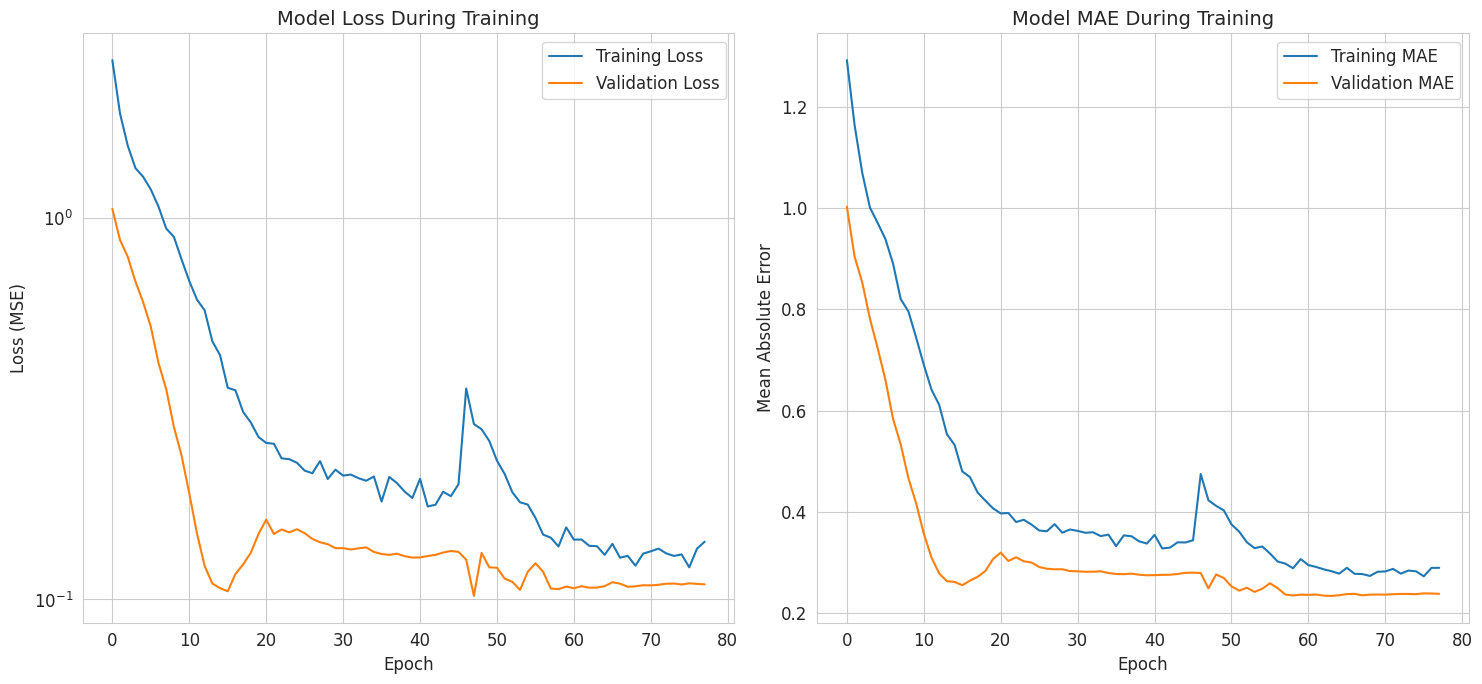


Training complete. Model saved as 'improved_lstm_model.h5'

Step 4: Evaluating model performance on validation data...
Evaluating model performance...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Root Mean Squared Error (RMSE): 22.13
Mean Absolute Error (MAE): 17.95
R² Score: -1.89


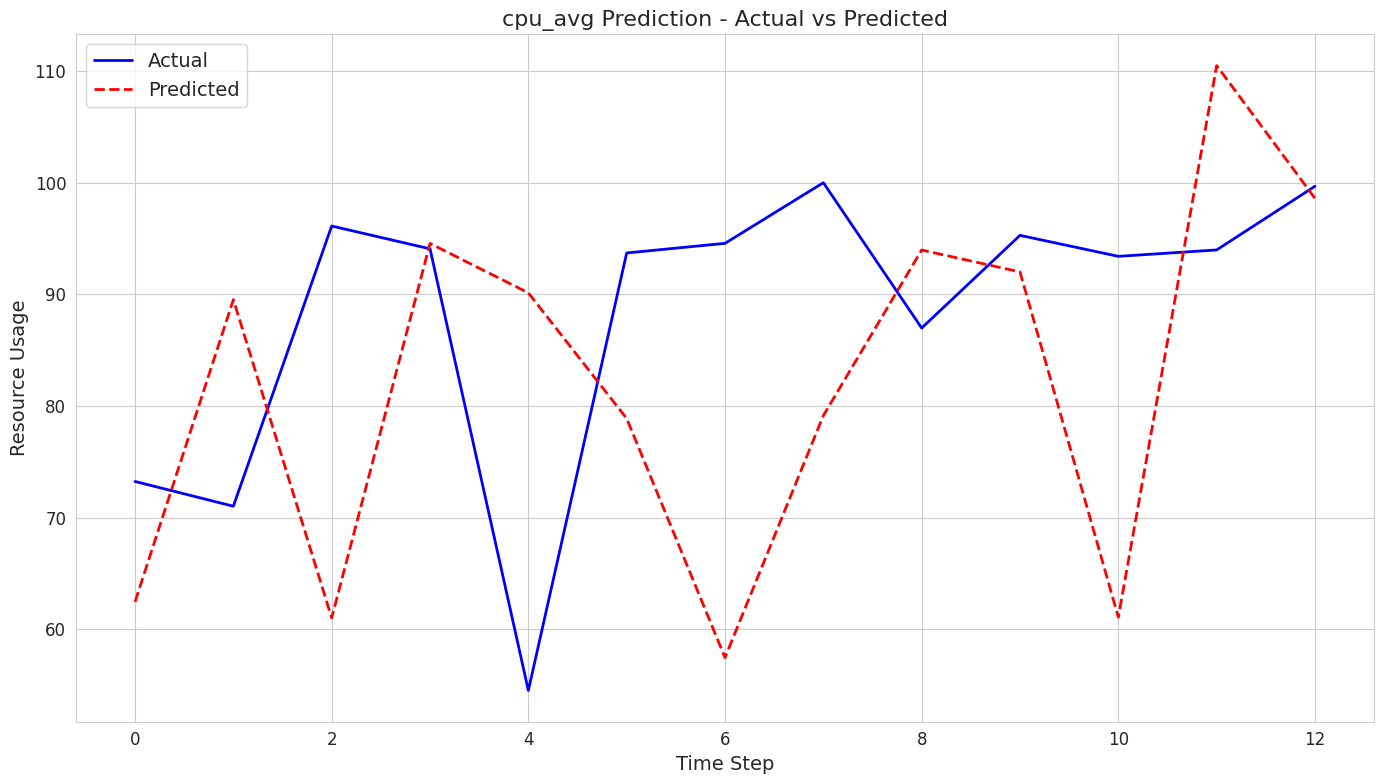

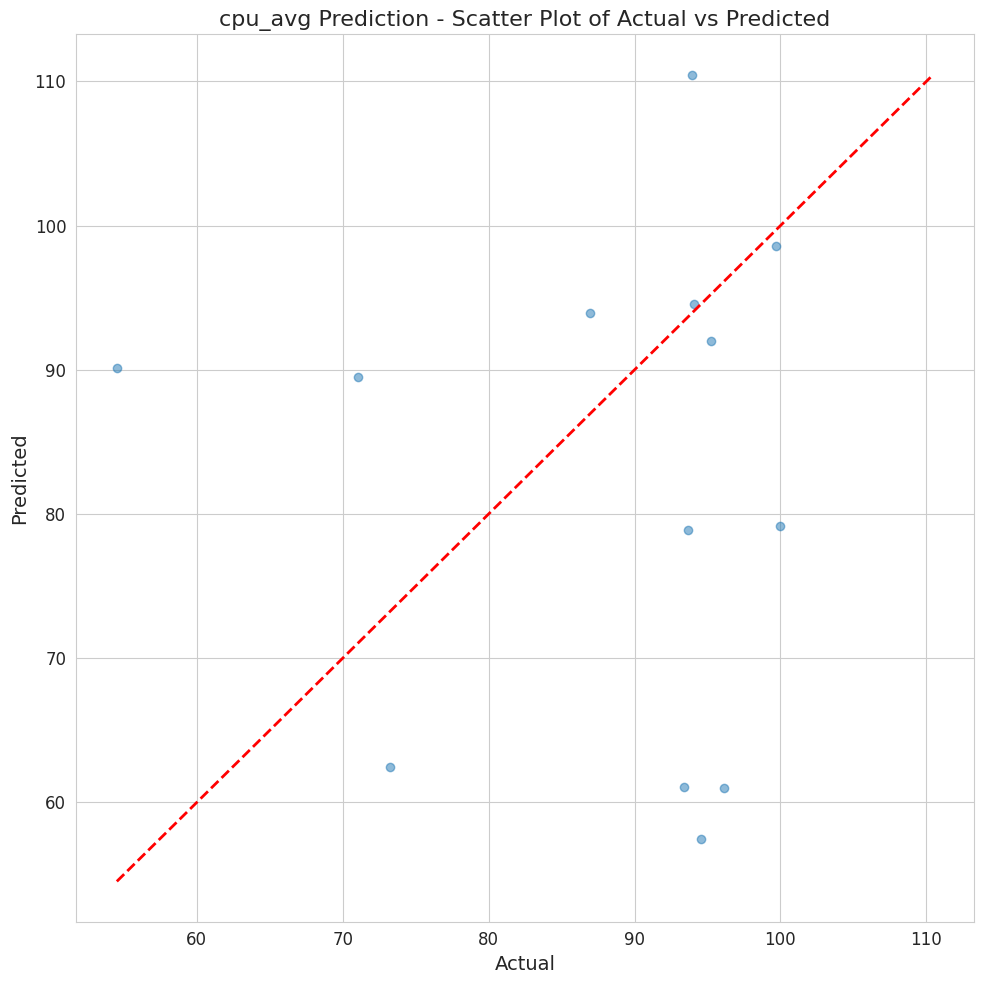

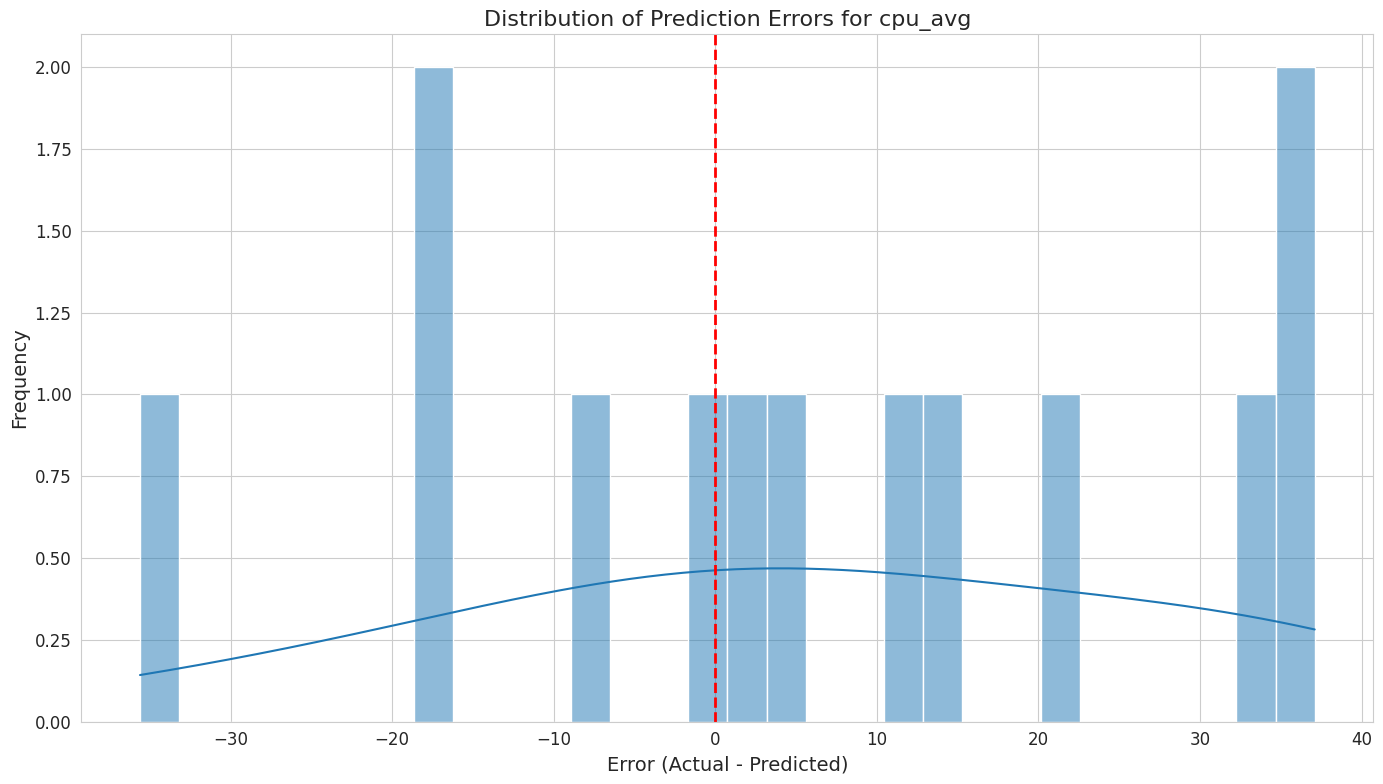


Error Statistics:
Mean Error: 5.94
Median Error: 3.28
Standard Deviation of Errors: 21.32
Min Error: -35.60
Max Error: 37.10


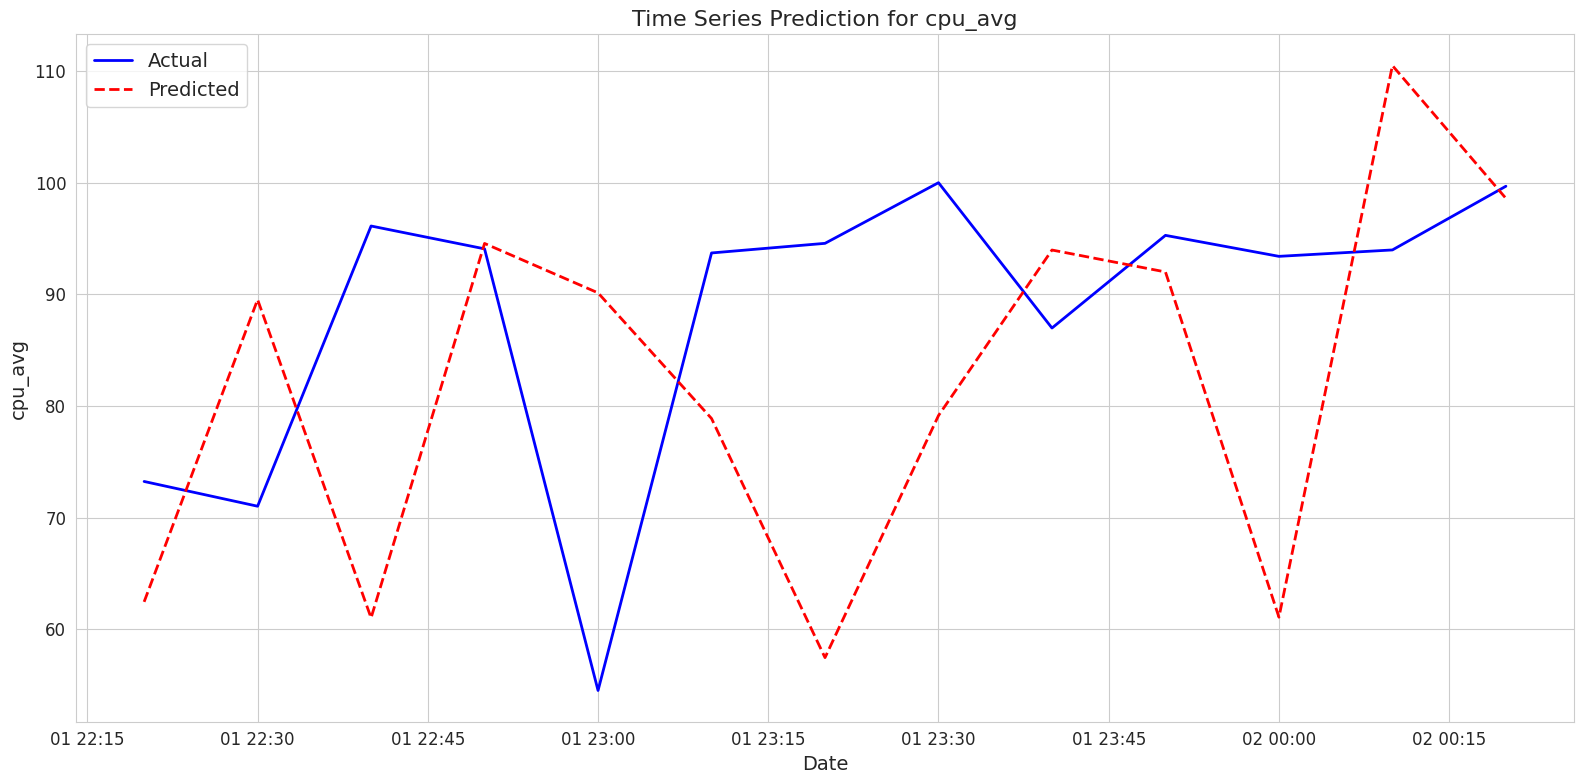

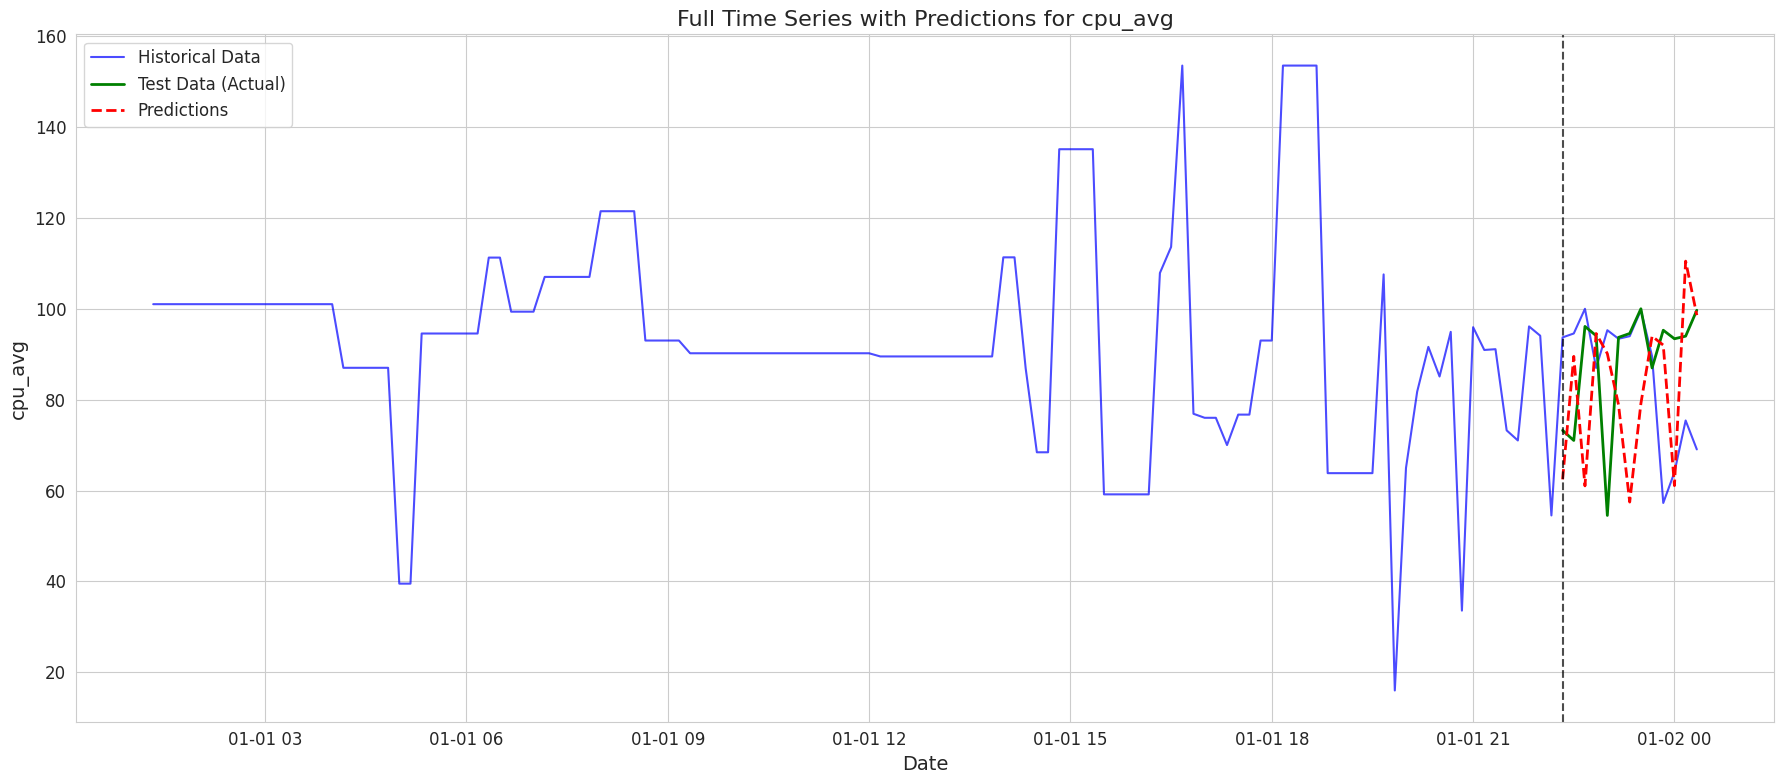


Step 5: Preparing test data sequences...
Preparing sequences for LSTM training...
Created 2 sequences with shape: (2, 6, 8)
Training set: (1, 6, 8), Validation set: (1, 6, 8)

Step 6: Evaluating on test data...
Evaluating model performance...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Root Mean Squared Error (RMSE): 37.01
Mean Absolute Error (MAE): 37.01
R² Score: nan


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


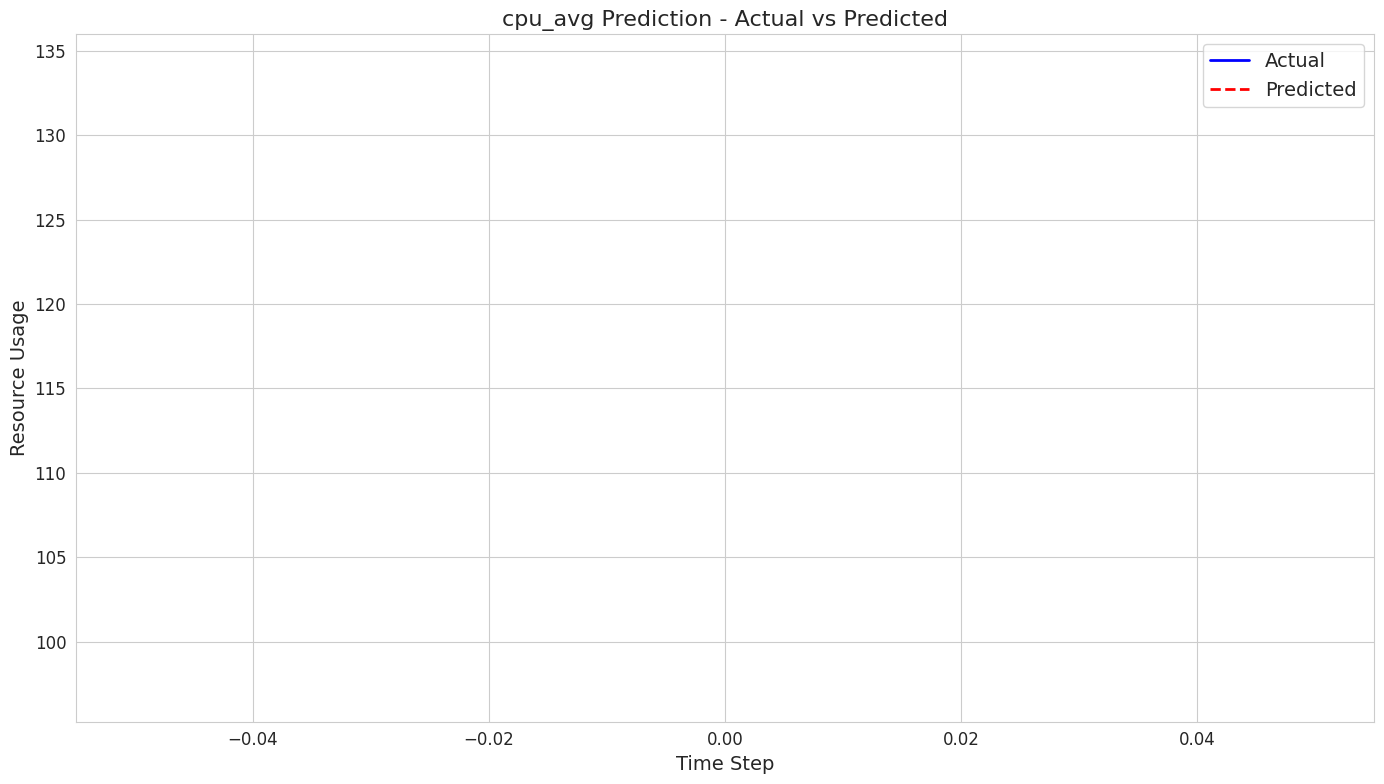

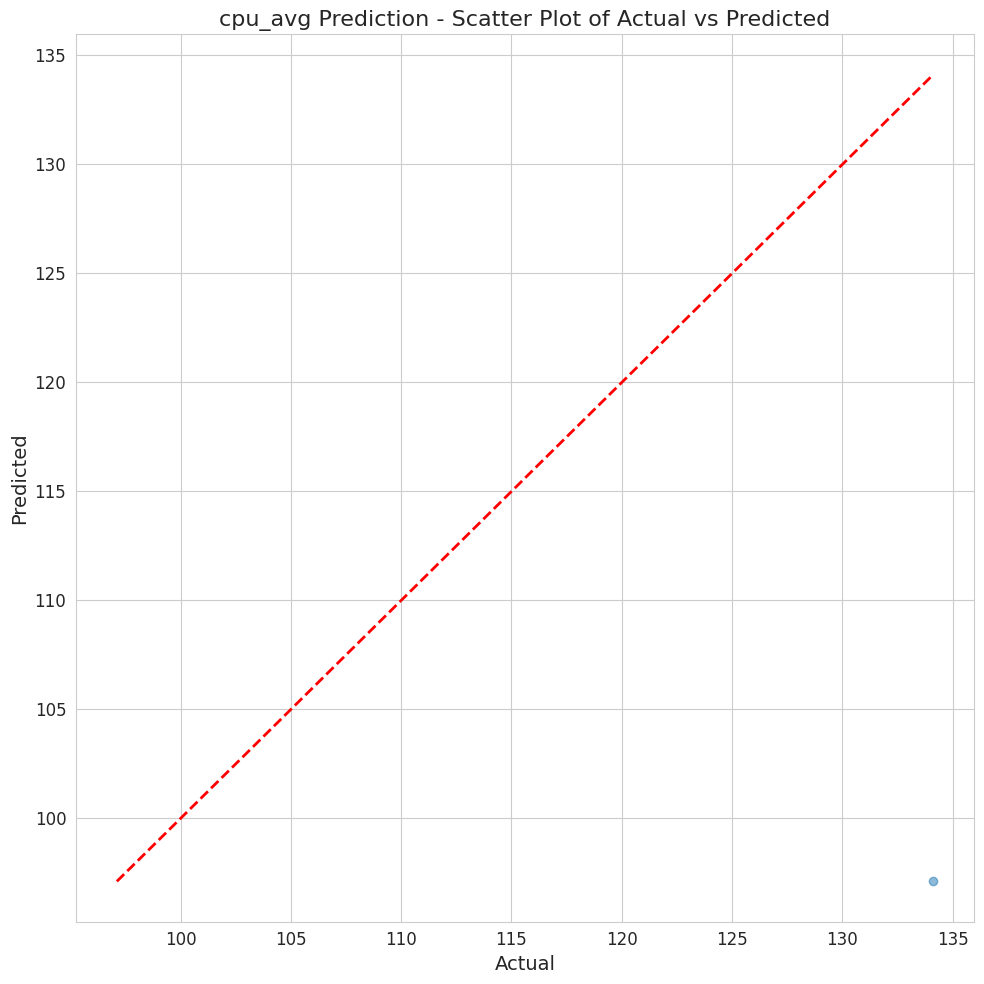

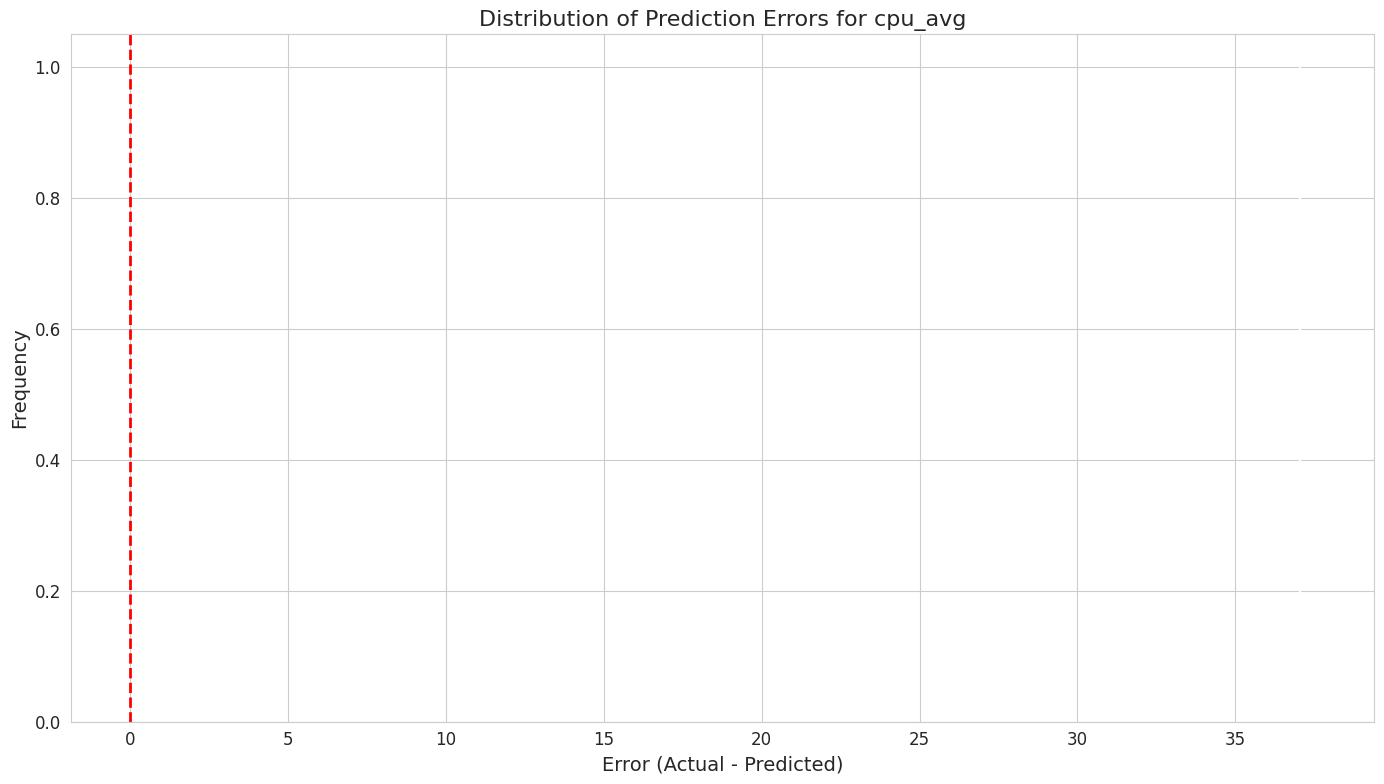


Error Statistics:
Mean Error: 37.01
Median Error: 37.01
Standard Deviation of Errors: 0.00
Min Error: 37.01
Max Error: 37.01


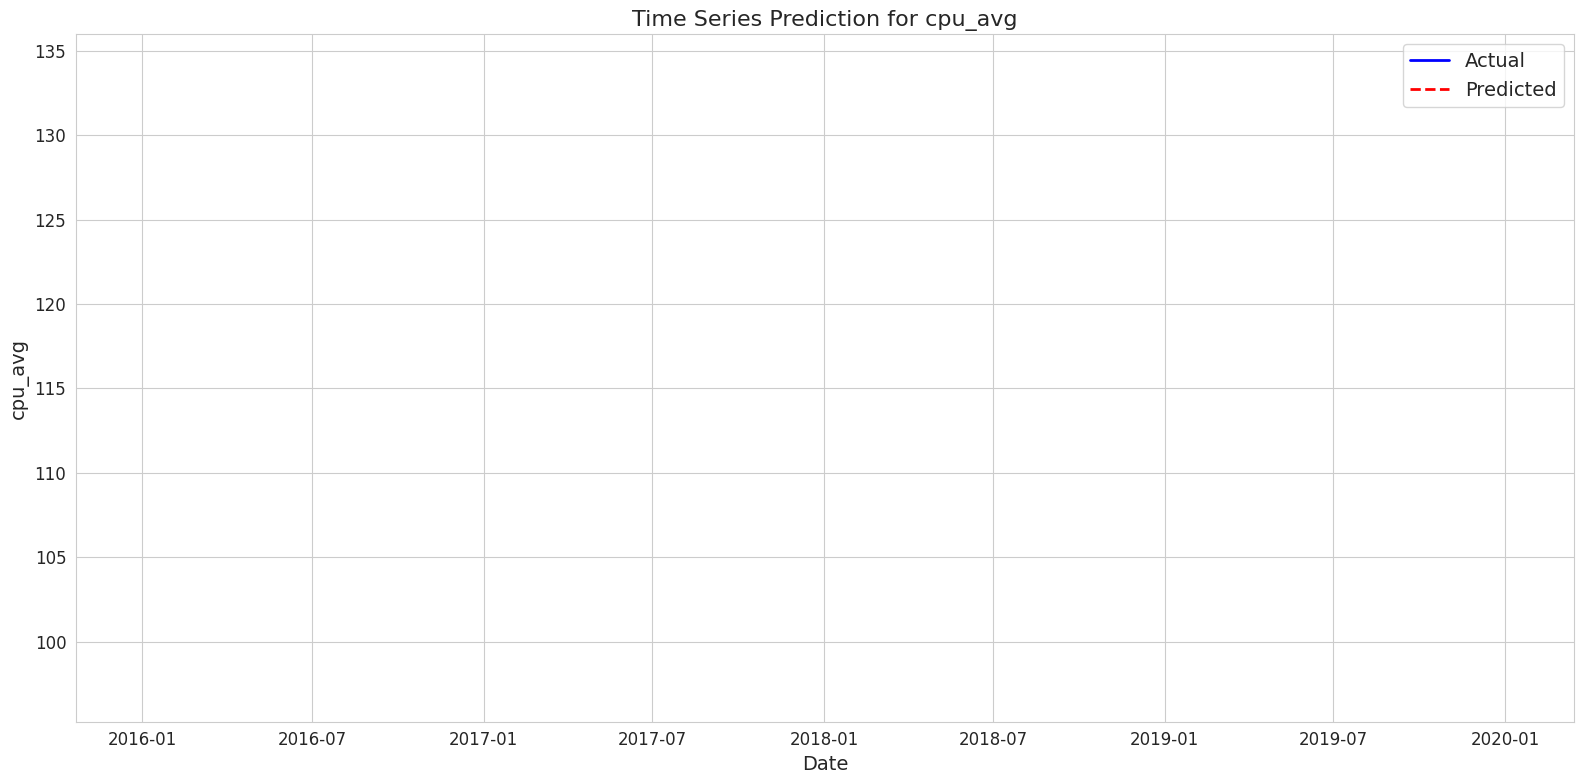

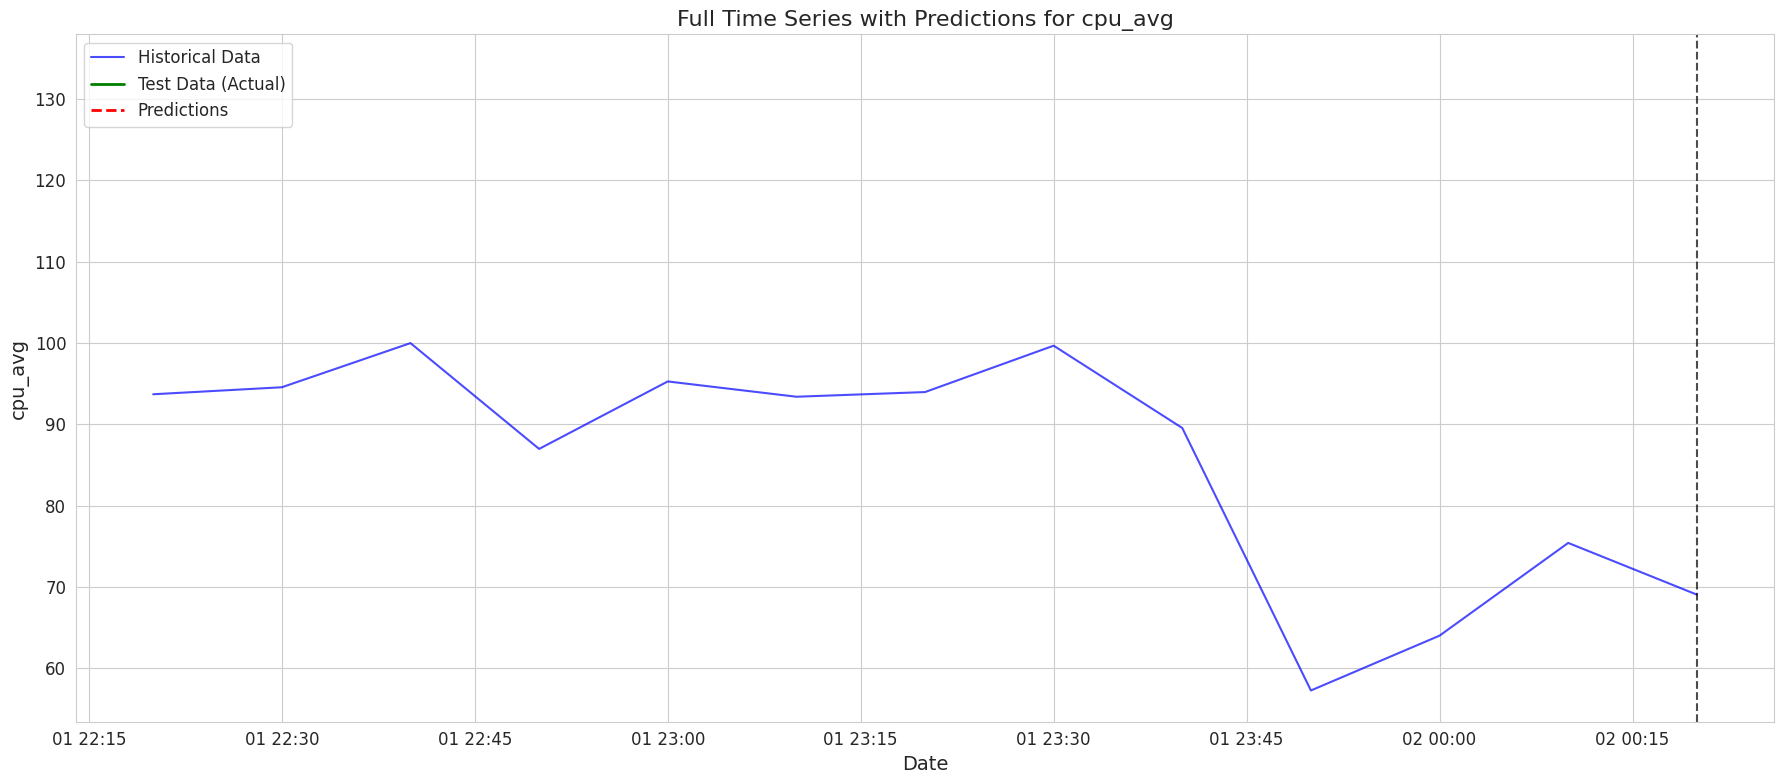


Test Evaluation Complete!

Generating future predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


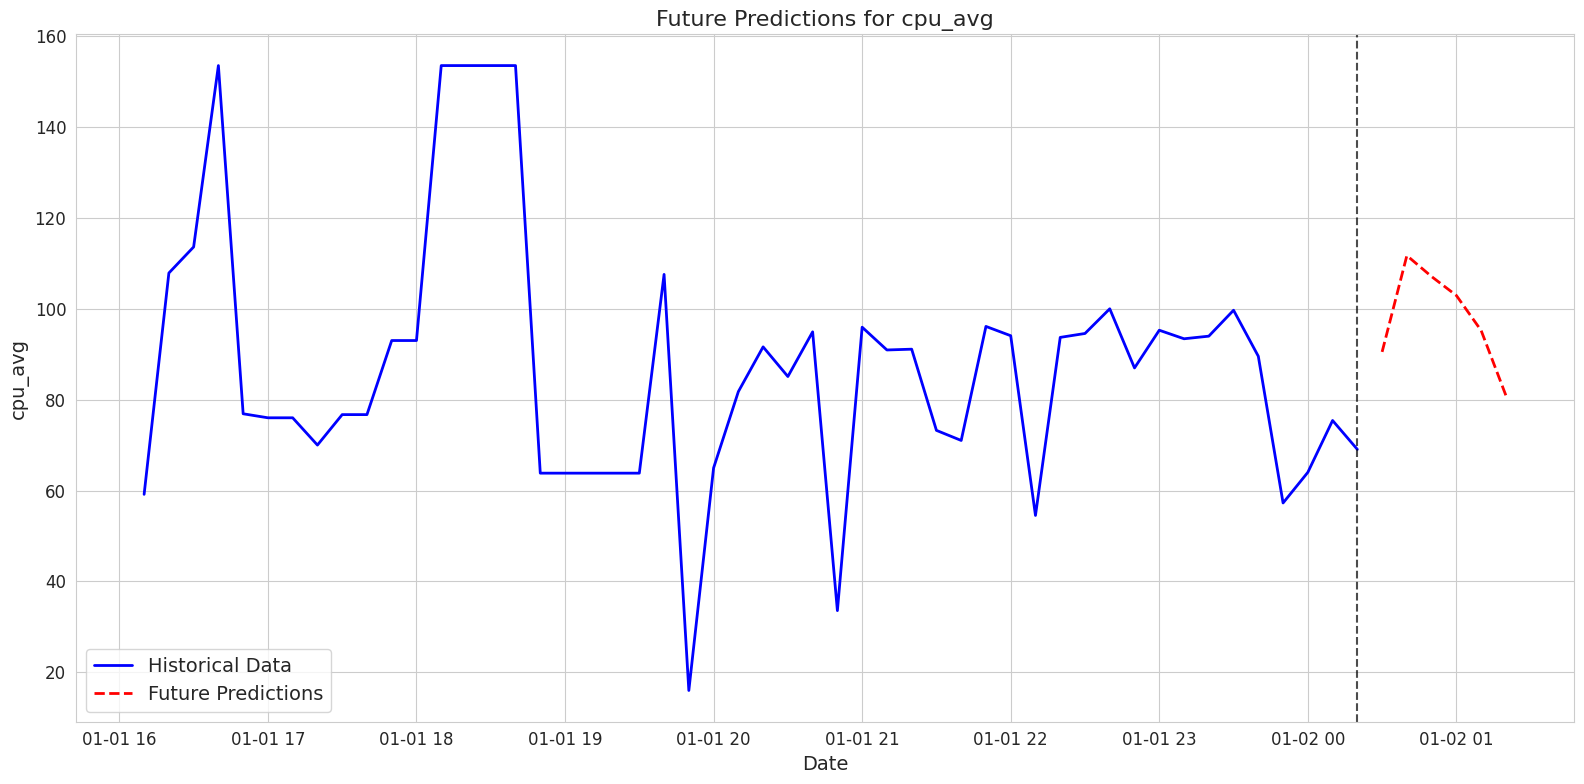


Future predictions generated and visualized.


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Set visual style for plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

class ImprovedCloudResourcePredictor:
    def __init__(self, lookback=12, prediction_horizon=6, feature_columns=None):
        """
        Initialize the Improved Cloud Resource Predictor

        Parameters:
        -----------
        lookback : int
            Number of time steps to look back for making predictions
        prediction_horizon : int
            Number of time steps to predict into the future
        feature_columns : list
            List of column names to use as features
        """
        self.lookback = lookback
        self.prediction_horizon = prediction_horizon
        self.feature_columns = feature_columns
        self.model = None
        self.feature_scaler = None
        self.target_scaler = None

    def load_and_preprocess_data(self, instance_file, task_file=None, resample_freq='10min'):
        """
        Load and preprocess the data with improved feature engineering

        Parameters:
        -----------
        instance_file : str
            Path to instance data file
        task_file : str
            Path to task data file
        resample_freq : str
            Frequency for resampling

        Returns:
        --------
        DataFrame with preprocessed data
        """
        # Override file paths with hardcoded values to ensure correct paths
        instance_file = "/content/batch_instance_24h_sample.csv"
        task_file = "/content/batch_task_24h_sample.csv"

        print("Loading and preprocessing data...")

        # Load batch_instance data
        instance_df = pd.read_csv(instance_file)

        # Convert timestamp to datetime
        instance_df['timestamp'] = pd.to_datetime('2018-01-01') + pd.to_timedelta(instance_df['start_time'], unit='s')

        # Remove outliers using IQR method
        for col in ['cpu_avg', 'cpu_max', 'mem_avg', 'mem_max']:
            if col in instance_df.columns:
                Q1 = instance_df[col].quantile(0.25)
                Q3 = instance_df[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                instance_df[col] = instance_df[col].clip(lower_bound, upper_bound)

        # Set timestamp as index
        instance_df.set_index('timestamp', inplace=True)

        # If task file is provided, load and merge with instance data
        if task_file:
            try:
                task_df = pd.read_csv(task_file)
                task_df['timestamp'] = pd.to_datetime('2018-01-01') + pd.to_timedelta(task_df['start_time'], unit='s')
                task_df.set_index('timestamp', inplace=True)

                # Extract only the relevant columns from task data
                task_features = task_df[['plan_cpu', 'plan_mem']]

                # Resample task data (using newer pandas methods to avoid warnings)
                task_resampled = task_features.resample(resample_freq).mean()

                # Keep track of the original columns before merging
                instance_columns = instance_df.columns.tolist()

                # Merge instance and task data
                merged_df = instance_df.join(task_resampled, how='left')

                # Fill missing values after merging (using newer pandas methods)
                for col in ['plan_cpu', 'plan_mem']:
                    if col in merged_df.columns:
                        merged_df[col] = merged_df[col].ffill().fillna(0)

                # Calculate ratios of actual to planned resources
                if 'cpu_avg' in instance_columns and 'plan_cpu' in merged_df.columns:
                    merged_df['cpu_usage_ratio'] = merged_df['cpu_avg'] / merged_df['plan_cpu'].replace(0, 1)
                if 'mem_avg' in instance_columns and 'plan_mem' in merged_df.columns:
                    merged_df['mem_usage_ratio'] = merged_df['mem_avg'] / merged_df['plan_mem'].replace(0, 1)

                df = merged_df
            except Exception as e:
                print(f"Error loading task file: {e}. Proceeding with instance data only.")
                df = instance_df
        else:
            df = instance_df

        # Resample data to reduce noise and create regular time intervals
        df_resampled = df.resample(resample_freq).mean().ffill()

        # Ensure data has no negative values for CPU or memory
        for col in ['cpu_avg', 'cpu_max', 'mem_avg', 'mem_max']:
            if col in df_resampled.columns:
                df_resampled[col] = df_resampled[col].clip(lower=0)

        # Add derived features for time of day patterns
        df_resampled['hour'] = df_resampled.index.hour
        df_resampled['minute'] = df_resampled.index.minute

        # Add cyclical time features
        df_resampled['hour_sin'] = np.sin(2 * np.pi * df_resampled['hour'] / 24)
        df_resampled['hour_cos'] = np.cos(2 * np.pi * df_resampled['hour'] / 24)
        df_resampled['minute_sin'] = np.sin(2 * np.pi * df_resampled['minute'] / 60)
        df_resampled['minute_cos'] = np.cos(2 * np.pi * df_resampled['minute'] / 60)
        df_resampled['weekday'] = df_resampled.index.dayofweek
        df_resampled['weekday_sin'] = np.sin(2 * np.pi * df_resampled['weekday'] / 7)
        df_resampled['weekday_cos'] = np.cos(2 * np.pi * df_resampled['weekday'] / 7)

        # Add exponential moving average features - better for time series
        for col in ['cpu_avg', 'cpu_max', 'mem_avg', 'mem_max']:
            if col in df_resampled.columns:
                df_resampled[f'{col}_ema_3'] = df_resampled[col].ewm(span=3).mean()
                df_resampled[f'{col}_ema_6'] = df_resampled[col].ewm(span=6).mean()
                df_resampled[f'{col}_ema_12'] = df_resampled[col].ewm(span=12).mean()

        # Add lag features with more lags for better pattern capturing
        if self.feature_columns is not None:
            for col in self.feature_columns:
                if col in df_resampled.columns:
                    for lag in [1, 2, 3]:  # Reduced number of lags to avoid too many features
                        lag_col = f'{col}_lag_{lag}'
                        df_resampled[lag_col] = df_resampled[col].shift(lag)

        # Add rolling statistics with simplified windows
        base_features = ['cpu_avg', 'cpu_max', 'mem_avg', 'mem_max']
        for col in base_features:
            if col in df_resampled.columns:
                # Rolling mean (single window for simplicity)
                df_resampled[f'{col}_rolling_mean_3'] = df_resampled[col].rolling(window=3).mean()

                # Add differencing features to capture rate of change
                df_resampled[f'{col}_diff'] = df_resampled[col].diff()

                # Momentum (simplified)
                df_resampled[f'{col}_momentum'] = df_resampled[col] - df_resampled[col].shift(3)

        # Drop rows with NaN values created by lag features
        df_resampled.dropna(inplace=True)

        return df_resampled

    def prepare_sequences(self, data, target_col):
        """
        Prepare sequences for LSTM training with dynamic lookback adjustment

        Parameters:
        -----------
        data : DataFrame
            Preprocessed time series data
        target_col : str
            Column name of the target variable

        Returns:
        --------
        X_train, X_val, y_train, y_val
        """
        print("Preparing sequences for LSTM training...")

        # Verify feature columns exist in data
        missing_features = [col for col in self.feature_columns if col not in data.columns]
        if missing_features:
            print(f"Error: Missing features in data: {missing_features}")
            print(f"Available columns: {data.columns.tolist()}")

            # Filter out missing features
            available_features = [col for col in self.feature_columns if col in data.columns]
            if len(available_features) > 0:
                print(f"Proceeding with available features: {available_features}")
                self.feature_columns = available_features
            else:
                print("No valid features remaining. Cannot proceed.")
                return None, None, None, None

        # Verify target column exists
        if target_col not in data.columns:
            print(f"Error: Target column '{target_col}' not found in data.")
            print(f"Available columns: {data.columns.tolist()}")
            return None, None, None, None

        # Check if we have enough data points and adjust lookback if needed
        min_required = self.lookback + self.prediction_horizon
        if len(data) < min_required:
            print(f"Warning: Not enough data points. Have {len(data)}, need at least {min_required}.")

            # Adjust lookback to work with available data
            original_lookback = self.lookback
            self.lookback = max(3, len(data) - self.prediction_horizon - 1)  # Ensure minimum lookback of 3
            print(f"Adjusted lookback from {original_lookback} to {self.lookback} to accommodate data size.")

            # Recheck if we still have enough data
            if len(data) < (self.lookback + self.prediction_horizon):
                print("Still not enough data after adjusting lookback. Cannot proceed.")
                return None, None, None, None

        try:
            # Select features
            features = data[self.feature_columns].values

            # Select target
            targets = data[[target_col]].values

            # Check for NaN or infinite values
            if np.isnan(features).any() or np.isinf(features).any():
                print("Warning: Feature data contains NaN or infinite values.")
                features = np.nan_to_num(features)
                print("Replaced NaN and infinite values to proceed.")

            if np.isnan(targets).any() or np.isinf(targets).any():
                print("Warning: Target data contains NaN or infinite values.")
                targets = np.nan_to_num(targets)
                print("Replaced NaN and infinite values to proceed.")

            # Scale features
            self.feature_scaler = RobustScaler()
            scaled_features = self.feature_scaler.fit_transform(features)

            # Scale target with MinMaxScaler using an expanded range
            self.target_scaler = MinMaxScaler(feature_range=(0, 2))  # Expanded range for better predictions
            scaled_targets = self.target_scaler.fit_transform(targets)

            # Create sequences
            X, y = [], []
            for i in range(len(scaled_features) - self.lookback - self.prediction_horizon + 1):
                X.append(scaled_features[i:i+self.lookback])
                y.append(scaled_targets[i+self.lookback:i+self.lookback+self.prediction_horizon])

            X, y = np.array(X), np.array(y)

            # Check if X or y is empty and handle the case
            if len(X) == 0 or len(y) == 0:
                print("Error: Not enough data points after creating sequences.")
                print("Consider reducing the lookback or prediction horizon, or providing more data.")
                return None, None, None, None

            print(f"Created {len(X)} sequences with shape: {X.shape}")

            # Reshape target for multi-step prediction if needed
            if self.prediction_horizon == 1:
                y = y.reshape(y.shape[0], y.shape[1])

            # Split data (using a larger validation set for small datasets)
            test_size = min(0.2, max(0.1, 5 / len(X)))  # Adaptive test size
            X_train, X_val, y_train, y_val = train_test_split(
                X, y, test_size=test_size, random_state=42, shuffle=False
            )

            print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}")
            return X_train, X_val, y_train, y_val

        except Exception as e:
            print(f"Error during sequence preparation: {str(e)}")
            import traceback
            traceback.print_exc()
            return None, None, None, None

    def build_model(self, input_shape):
        """
        Build an improved LSTM model architecture with simplified structure

        Parameters:
        -----------
        input_shape : tuple
            Shape of input sequences

        Returns:
        --------
        Compiled Keras model
        """
        print("Building improved LSTM model...")
        model = Sequential()

        # First LSTM layer with fewer units
        model.add(Bidirectional(
            LSTM(64, return_sequences=True, dropout=0.1, recurrent_dropout=0.1),
            input_shape=input_shape
        ))
        model.add(BatchNormalization())

        # Second LSTM layer - reduced complexity
        model.add(Bidirectional(LSTM(32, return_sequences=False)))
        model.add(BatchNormalization())
        model.add(Dropout(0.1))  # Reduced dropout

        # Dense layer - Simplified architecture
        model.add(Dense(32, activation='relu'))  # Changed to ReLU
        model.add(BatchNormalization())
        model.add(Dropout(0.1))

        # Output layer with linear activation for unrestricted range
        model.add(Dense(self.prediction_horizon, activation='linear'))

        # Compile model with MSE loss
        model.compile(
            optimizer=Adam(learning_rate=0.001),  # Higher learning rate
            loss='mse',
            metrics=['mae']
        )

        return model

    def train_model(self, X_train, y_train, X_val, y_val, batch_size=32, epochs=2000):
        """
        Train the LSTM model with improved parameters

        Parameters:
        -----------
        X_train, y_train : numpy arrays
            Training data
        X_val, y_val : numpy arrays
            Validation data
        batch_size : int
            Batch size for training
        epochs : int
            Maximum number of epochs

        Returns:
        --------
        Training history or None if error
        """
        print("Training improved LSTM model...")

        # Check if inputs are None
        if X_train is None or y_train is None or X_val is None or y_val is None:
            print("Error: Cannot train model with None inputs. Check prepare_sequences output.")
            return None

        try:
            # Define callbacks with better parameters
            callbacks = [
                EarlyStopping(
                    monitor='val_loss',
                    patience=30,  # Moderate patience
                    restore_best_weights=True,
                    min_delta=0.001,  # Less sensitive to minor improvements
                    verbose=1
                ),
                ReduceLROnPlateau(
                    monitor='val_loss',
                    factor=0.2,  # Larger reduction factor
                    patience=10,
                    min_lr=0.0001,  # Not too small
                    verbose=1
                ),
                ModelCheckpoint(
                    'best_lstm_model.h5',
                    monitor='val_loss',
                    save_best_only=True,
                    verbose=1
                )
            ]

            # Build model
            print(f"Input shape for model: {X_train.shape[1:]}")
            self.model = self.build_model(X_train.shape[1:])

            # Model summary
            self.model.summary()

            # Train first phase
            print("Starting first training phase...")
            history1 = self.model.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=epochs // 2,
                batch_size=batch_size,
                callbacks=callbacks,
                verbose=1,
                shuffle=True  # Enable shuffling for better generalization
            )

            # Learning rate restart - reset optimizer with higher learning rate
            print("Resetting learning rate for second training phase...")
            self.model.optimizer.learning_rate.assign(0.002)  # Higher restart LR

            # Continue training
            print("Starting second training phase...")
            history2 = self.model.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=epochs // 2,
                batch_size=batch_size,
                callbacks=callbacks,
                verbose=1,
                shuffle=True
            )

            # Combine histories
            combined_history = {}
            for k in history1.history.keys():
                combined_history[k] = history1.history[k] + history2.history[k]

            # Return custom history object
            class CombinedHistory:
                def __init__(self, history_dict):
                    self.history = history_dict

            return CombinedHistory(combined_history)

        except Exception as e:
            print(f"Error during model training: {str(e)}")
            import traceback
            traceback.print_exc()
            return None

    def evaluate_model(self, X_test, y_test, data=None, target_col=None):
        """
        Evaluate the model on test data and generate visualizations

        Parameters:
        -----------
        X_test, y_test : numpy arrays
            Test data
        data : DataFrame
            Original data for plotting time series
        target_col : str
            Name of the target column

        Returns:
        --------
        Dictionary of evaluation metrics and visualization results
        """
        print("Evaluating model performance...")

        if self.model is None:
            print("Error: Model has not been trained yet.")
            return None

        try:
            # Make predictions
            y_pred = self.model.predict(X_test)

            # Inverse transform predictions and actual values
            y_test_inv = self.target_scaler.inverse_transform(y_test.reshape(y_test.shape[0], self.prediction_horizon))
            y_pred_inv = self.target_scaler.inverse_transform(y_pred)

            # Ensure no negative predictions
            y_pred_inv = np.maximum(0, y_pred_inv)

            # Calculate metrics for the first prediction step
            metrics = {
                'rmse': np.sqrt(mean_squared_error(y_test_inv[:, 0], y_pred_inv[:, 0])),
                'mae': mean_absolute_error(y_test_inv[:, 0], y_pred_inv[:, 0]),
                'r2': r2_score(y_test_inv[:, 0], y_pred_inv[:, 0])
            }

            print(f"Root Mean Squared Error (RMSE): {metrics['rmse']:.2f}")
            print(f"Mean Absolute Error (MAE): {metrics['mae']:.2f}")
            print(f"R² Score: {metrics['r2']:.2f}")

            # Plot actual vs predicted values
            self._plot_predictions(y_test_inv, y_pred_inv, f'{target_col} Prediction')

            # Plot prediction error distribution
            self._plot_error_distribution(y_test_inv[:, 0], y_pred_inv[:, 0], target_col)

            # If time series data is provided, plot predictions on the timeline
            if data is not None and target_col is not None:
                self._plot_time_series_predictions(X_test, y_test_inv, y_pred_inv, data, target_col)

            return metrics, y_test_inv, y_pred_inv

        except Exception as e:
            print(f"Error during model evaluation: {str(e)}")
            import traceback
            traceback.print_exc()
            return None

    def _plot_predictions(self, y_true, y_pred, title):
        """
        Plot actual vs predicted values

        Parameters:
        -----------
        y_true : numpy array
            Actual values
        y_pred : numpy array
            Predicted values
        title : str
            Plot title
        """
        plt.figure(figsize=(14, 8))

        # Plot actual values for first prediction step
        plt.plot(y_true[:, 0], 'b-', linewidth=2, label='Actual')

        # Plot predicted values for first prediction step
        plt.plot(y_pred[:, 0], 'r--', linewidth=2, label='Predicted')

        plt.title(f"{title} - Actual vs Predicted", fontsize=16)
        plt.xlabel('Time Step', fontsize=14)
        plt.ylabel('Resource Usage', fontsize=14)
        plt.legend(fontsize=14)
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"{title.lower().replace(' ', '_')}_comparison.png", dpi=300)
        plt.show()

        # Plot scatter of actual vs predicted with perfect prediction line
        plt.figure(figsize=(10, 10))
        plt.scatter(y_true[:, 0], y_pred[:, 0], alpha=0.5)

        # Add perfect prediction line
        min_val = min(np.min(y_true[:, 0]), np.min(y_pred[:, 0]))
        max_val = max(np.max(y_true[:, 0]), np.max(y_pred[:, 0]))
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)

        plt.title(f"{title} - Scatter Plot of Actual vs Predicted", fontsize=16)
        plt.xlabel('Actual', fontsize=14)
        plt.ylabel('Predicted', fontsize=14)
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"{title.lower().replace(' ', '_')}_scatter.png", dpi=300)
        plt.show()

    def _plot_error_distribution(self, y_true, y_pred, target_col):
        """
        Plot the distribution of prediction errors

        Parameters:
        -----------
        y_true : numpy array
            Actual values
        y_pred : numpy array
            Predicted values
        target_col : str
            Name of the target column
        """
        # Calculate errors
        errors = y_true - y_pred

        # Plot error distribution
        plt.figure(figsize=(14, 8))
        sns.histplot(errors, kde=True, bins=30)
        plt.axvline(0, color='r', linestyle='--', linewidth=2)
        plt.title(f"Distribution of Prediction Errors for {target_col}", fontsize=16)
        plt.xlabel('Error (Actual - Predicted)', fontsize=14)
        plt.ylabel('Frequency', fontsize=14)
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"{target_col.lower()}_error_distribution.png", dpi=300)
        plt.show()

        # Summary statistics of errors
        print("\nError Statistics:")
        print(f"Mean Error: {np.mean(errors):.2f}")
        print(f"Median Error: {np.median(errors):.2f}")
        print(f"Standard Deviation of Errors: {np.std(errors):.2f}")
        print(f"Min Error: {np.min(errors):.2f}")
        print(f"Max Error: {np.max(errors):.2f}")

    def _plot_time_series_predictions(self, X_test, y_true, y_pred, data, target_col):
        """
        Plot predictions on the actual timeline

        Parameters:
        -----------
        X_test : numpy array
            Test features
        y_true : numpy array
            Actual values
        y_pred : numpy array
            Predicted values
        data : DataFrame
            Original time series data
        target_col : str
            Name of the target column
        """
        try:
            # Get the last chunk of data for timeline plotting
            test_size = len(X_test)
            last_data = data.iloc[-test_size-self.lookback:]

            # Create a DataFrame with predictions and actual values
            test_dates = last_data.index[-test_size:]
            pred_df = pd.DataFrame({
                'Actual': y_true[:, 0],
                'Predicted': y_pred[:, 0]
            }, index=test_dates)

            # Plot time series with predictions
            plt.figure(figsize=(16, 8))
            plt.plot(pred_df.index, pred_df['Actual'], 'b-', linewidth=2, label='Actual')
            plt.plot(pred_df.index, pred_df['Predicted'], 'r--', linewidth=2, label='Predicted')

            plt.title(f"Time Series Prediction for {target_col}", fontsize=16)
            plt.xlabel('Date', fontsize=14)
            plt.ylabel(target_col, fontsize=14)
            plt.legend(fontsize=14)
            plt.grid(True)
            plt.tight_layout()
            plt.savefig(f"{target_col.lower()}_time_series_pred.png", dpi=300)
            plt.show()

            # Plot the full time series with predictions to see in context
            plt.figure(figsize=(18, 8))

            # Plot all historical data
            plt.plot(data.index, data[target_col], 'b-', linewidth=1.5, alpha=0.7, label='Historical Data')

            # Highlight the test period with predictions
            plt.plot(pred_df.index, pred_df['Actual'], 'g-', linewidth=2, label='Test Data (Actual)')
            plt.plot(pred_df.index, pred_df['Predicted'], 'r--', linewidth=2, label='Predictions')

            # Add a vertical line to mark the start of test data
            plt.axvline(x=pred_df.index[0], color='k', linestyle='--', alpha=0.7)

            plt.title(f"Full Time Series with Predictions for {target_col}", fontsize=16)
            plt.xlabel('Date', fontsize=14)
            plt.ylabel(target_col, fontsize=14)
            plt.legend(fontsize=12)
            plt.grid(True)
            plt.tight_layout()
            plt.savefig(f"{target_col.lower()}_full_time_series_pred.png", dpi=300)
            plt.show()

        except Exception as e:
            print(f"Error in time series plotting: {str(e)}")
            import traceback
            traceback.print_exc()

# Helper functions
def augment_training_data(X_train, y_train, noise_level=0.05):
    """Add small amounts of Gaussian noise to training data to improve generalization"""
    X_noise = np.random.normal(0, noise_level, X_train.shape)
    y_noise = np.random.normal(0, noise_level/2, y_train.shape)

    X_aug = np.concatenate([X_train, X_train + X_noise], axis=0)
    y_aug = np.concatenate([y_train, y_train + y_noise], axis=0)

    # Shuffle the augmented data
    indices = np.arange(len(X_aug))
    np.random.shuffle(indices)

    return X_aug[indices], y_aug[indices]

def plot_training_history(history):
    """Plot the training history with improved visualization"""
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss During Training', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss (MSE)', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.yscale('log')  # Log scale often better for loss visualization

    # Plot MAE
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Model MAE During Training', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Mean Absolute Error', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300)
    plt.show()

def make_future_predictions(predictor, data, target_col, steps_ahead=12):
    """Generate and visualize future predictions"""
    print("\nGenerating future predictions...")

    # Get the most recent data for prediction
    recent_data = data.iloc[-predictor.lookback:]

    # Extract features for prediction
    features = recent_data[predictor.feature_columns].values
    scaled_features = predictor.feature_scaler.transform(features)
    X_pred = scaled_features.reshape(1, predictor.lookback, len(predictor.feature_columns))

    # Make prediction
    pred_scaled = predictor.model.predict(X_pred)
    pred = predictor.target_scaler.inverse_transform(pred_scaled)[0]

    # Ensure no negative predictions
    pred = np.maximum(0, pred)

    # Generate future timestamps
    last_time = recent_data.index[-1]
    future_times = pd.date_range(
        start=last_time + pd.Timedelta(minutes=10),
        periods=predictor.prediction_horizon,
        freq='10min'
    )

    # Create prediction DataFrame
    future_df = pd.DataFrame({
        'predicted_cpu_avg': pred
    }, index=future_times)

    # Plot the predictions
    plt.figure(figsize=(16, 8))

    # Plot historical data
    plt.plot(data.index[-50:], data[target_col][-50:], 'b-',
             linewidth=2, label='Historical Data')

    # Plot predictions
    plt.plot(future_df.index, future_df['predicted_cpu_avg'], 'r--',
             linewidth=2, label='Future Predictions')

    # Add vertical line to mark prediction start
    plt.axvline(x=last_time, color='k', linestyle='--', alpha=0.7)

    plt.title(f"Future Predictions for {target_col}", fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel(target_col, fontsize=14)
    plt.legend(fontsize=14)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('future_predictions.png', dpi=300)
    plt.show()

    return future_df

def main():
    """
    Main function with improved configuration to fix the model's prediction issues
    """
    # Define paths to data files
    batch_instance_file = '/content/batch_instance_24h_sample.csv'
    batch_task_file = '/content/batch_task_24h_sample.csv'

    # IMPORTANT: Reduced lookback to ensure it works with your data sample
    lookback = 6  # Further reduced from 12 to better match available data points
    prediction_horizon = 6  # Keep at 6 as it works

    # Use only essential features to start with
    feature_columns = [
        'cpu_avg',  # Target feature itself
        'cpu_max',  # Max utilization
        'hour_sin', # Time component
        'hour_cos'  # Time component
    ]

    # Target column
    target_col = 'cpu_avg'

    print(f"Creating predictor with lookback={lookback}, prediction_horizon={prediction_horizon}")
    print(f"Using initial feature columns: {feature_columns}")

    # Create predictor instance
    predictor = ImprovedCloudResourcePredictor(
        lookback=lookback,
        prediction_horizon=prediction_horizon,
        feature_columns=feature_columns
    )

    try:
        # Load and preprocess data
        print("\nStep 1: Loading and preprocessing data...")
        data = predictor.load_and_preprocess_data(
            instance_file=batch_instance_file,
            task_file=batch_task_file,
            resample_freq='10min'
        )

        if data is None or len(data) == 0:
            print("Error: No data available after preprocessing.")
            return None, None, None

        print(f"Preprocessed data shape: {data.shape}")

        # Add newly created features that should exist in data now
        additional_features = [
            'minute_sin',
            'minute_cos',
            'cpu_avg_ema_3',
            'cpu_avg_diff'
        ]

        # Update feature columns to include additional features that exist
        all_features = feature_columns.copy()
        for feature in additional_features:
            if feature in data.columns:
                all_features.append(feature)

        print(f"Updating feature columns to: {all_features}")
        predictor.feature_columns = all_features

        # Prepare sequences
        print("\nStep 2: Preparing sequences for LSTM...")
        X_train, X_val, y_train, y_val = predictor.prepare_sequences(data, target_col)

        if X_train is None:
            print("Error: Failed to prepare sequences. Exiting.")
            return None, None, None

        # IMPORTANT: Data augmentation for small datasets
        print("\nStep 2.5: Performing data augmentation...")
        X_train_aug, y_train_aug = augment_training_data(X_train, y_train)
        print(f"Augmented training data size: {X_train_aug.shape}")

        # Train model with optimized parameters
        print("\nStep 3: Training the LSTM model...")
        history = predictor.train_model(
            X_train_aug, y_train_aug, X_val, y_val,
            batch_size=16,  # Smaller batch size for small datasets
            epochs=300      # Extended epochs for longer training
        )

        if history is None:
            print("Error: Model training failed. Exiting.")
            return None, None, None

        # Plot training history
        plot_training_history(history)

        # Save the model
        if predictor.model is not None:
            predictor.model.save('improved_lstm_model.h5')
            print("\nTraining complete. Model saved as 'improved_lstm_model.h5'")
        else:
            print("\nError: Model is None, cannot save.")

        # Evaluate on validation data
        print("\nStep 4: Evaluating model performance on validation data...")
        eval_results = predictor.evaluate_model(X_val, y_val, data, target_col)

        # Use a small portion of data as test set since we have limited data
        test_size = max(5, int(len(data) * 0.1))  # At least 5 samples
        test_data = data.iloc[-test_size:]

        # Create a separate test predictor with adjusted lookback if needed
        print("\nStep 5: Preparing test data sequences...")
        test_lookback = min(lookback, len(test_data) - prediction_horizon - 1)

        if test_lookback < 3:
            print("Warning: Not enough test data for proper evaluation.")
            print("Skipping separate test evaluation.")
        else:
            test_predictor = ImprovedCloudResourcePredictor(
                lookback=test_lookback,
                prediction_horizon=prediction_horizon,
                feature_columns=predictor.feature_columns
            )

            # Prepare test data
            X_test, _, y_test, _ = test_predictor.prepare_sequences(test_data, target_col)

            # Copy trained model parameters to test predictor
            test_predictor.model = predictor.model
            test_predictor.feature_scaler = predictor.feature_scaler
            test_predictor.target_scaler = predictor.target_scaler

            if X_test is not None and len(X_test) > 0:
                print("\nStep 6: Evaluating on test data...")
                test_metrics = test_predictor.evaluate_model(X_test, y_test, test_data, target_col)
                print("\nTest Evaluation Complete!")

            # Make future predictions
            future_preds = make_future_predictions(predictor, data, target_col)
            print("\nFuture predictions generated and visualized.")

        return predictor, data, history

    except Exception as e:
        print(f"Error in main execution: {str(e)}")
        import traceback
        traceback.print_exc()
        return None, None, None

if __name__ == "__main__":
    # Add better error handling for the main function
    try:
        predictor, data, history = main()
        if predictor is None:
            print("Main function execution failed. Please check the error messages above.")
    except Exception as e:
        print(f"Critical error in program execution: {str(e)}")
        import traceback
        traceback.print_exc()